# Welcome: VIX Trading Strategy for Mathematicians

**Note:** You're a 2nd year pure math student, so this notebook uses mathematical rigor while building intuition for finance.

## What This Notebook Does (Executive Summary)

We'll implement a **volatility trading system** that:
1. **Detects** different market regimes using clustering & Z-scores
2. **Generates signals** using mean reversion & trend analysis
3. **Prices options** using Black-Scholes PDE
4. **Backtests strategies** with rigorous performance metrics
5. **Optimizes position sizing** using Kelly Criterion

**Time estimate:** 2-3 hours to understand completely

---

## Module Structure (Like Courses at KTH)

```
Course 1: Probability & Statistics
  - Market regimes detection
  - Distribution analysis
  - Hypothesis testing

Course 2: Differential Equations  
  - Black-Scholes PDE
  - Option pricing
  - Greeks (derivatives)

Course 3: Linear Algebra & Optimization
  - K-means clustering
  - Portfolio optimization
  - Risk metrics

Course 4: Real Analysis
  - Cumulative returns (Lebesgue integration)
  - Convergence of strategies
  - Tail risk (CVaR)
```

Your goal: Understand how pure math concepts solve real financial problems.

# Mathematical Foundation: Why This Matters

## The Core Problem (Rigorous)

**Definition:** A volatility process is a stochastic process $\{V_t\}_{t \geq 0}$ modeling market fear.

**Observation:** In real markets, $V_t$ exhibits mean reversion:
$$V_t = \mu + \sigma \cdot Z_t + \text{AR(1) component}$$

where:
- $\mu \approx 17$ (long-term mean VIX level)
- $\sigma \approx 5$ (standard deviation)
- $Z_t \sim N(0,1)$ (standard normal shocks)

**Key Insight:** When $V_t$ deviates from $\mu$ by more than $2\sigma$, it tends to revert.

**This is our edge:** A **stationarity assumption** we can test.

---

## Three Mathematical Questions We Answer

### Q1: Statistical Testing (Hypothesis Tests)

**H₀ (Null):** VIX changes are random walk (no pattern)
$$\Delta V_t \sim N(0, \sigma^2)$$

**H₁ (Alternative):** VIX reverts to mean (pattern exists)
$$V_t = \alpha + \beta V_{t-1} + \epsilon_t, \quad |\beta| < 1$$

**Method:** Augmented Dickey-Fuller (ADF) test
- If p-value < 0.05: **Reject H₀** → mean reversion exists
- If p-value > 0.05: **Fail to reject H₀** → random walk behavior

**Your job:** Estimate $\beta$ and test significance.

---

### Q2: Regime Detection (K-Means Clustering)

**Problem:** Market has multiple "modes." Detect them using optimization.

**Setup:** Partition data into $k=3$ clusters by minimizing:
$$J = \sum_{i=1}^{k} \sum_{x \in C_i} \|x - \mu_i\|^2$$

where:
- $C_i$ = cluster $i$
- $\mu_i$ = centroid of cluster $i$
- $x$ = feature vector (VIX, vol-of-vol, rolling volatility)

**Interpretation:**
- Cluster 1: Low volatility regime
- Cluster 2: Normal regime  
- Cluster 3: High volatility (crisis)

**Math insight:** This is **convex optimization** on discrete assignments.

---

### Q3: Option Pricing (PDE Solution)

**Black-Scholes PDE:**
$$\frac{\partial C}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 C}{\partial S^2} + rS\frac{\partial C}{\partial S} - rC = 0$$

with boundary condition: $C(S_T, T) = \max(S_T - K, 0)$

**This PDE says:** The option price $C(S, t)$ is determined by:
- Time decay (theta = $\frac{\partial C}{\partial t}$)
- Convexity (gamma = $\frac{\partial^2 C}{\partial S^2}$)
- Delta hedging (delta = $\frac{\partial C}{\partial S}$)

**Our approach:** Solve numerically using scipy to get Greeks.

---

## Why These Math Concepts?

| Concept | Use in Notebook | Real Benefit |
|---------|-----------------|-------------|
| **Stochastic processes** | Model VIX dynamics | Understand market behavior |
| **Hypothesis testing** | Verify mean reversion | Know if strategy works |
| **Optimization** | Find clusters & position sizes | Maximize risk-adjusted returns |
| **PDEs** | Price options | Hedge portfolio properly |
| **Statistics** | Compute Sharpe ratio, drawdowns | Measure strategy quality |

---

## How to Read This Notebook

1. **Skip formulas on first read** (understand intuition)
2. **Review code comments** (they explain math)
3. **Check assumptions** (all strategies have them)
4. **Validate results** (run diagnostics)
5. **Don't trust backtests blindly** (they're biased)

# VIX Volatility Trading Strategy with Futures and Options

This notebook develops and backtests a comprehensive volatility trading strategy using VIX (Volatility Index) futures and options. We will:
- Analyze historical VIX data
- Build volatility regime detection models
- Implement multiple trading strategies
- Backtest strategies across different market conditions
- Measure effectiveness and risk metrics

## 1. Overview & Purpose (From First Principles)

### What is the VIX? (Formal Definition)

**Definition:** The VIX is the **implied volatility** of at-the-money (ATM) S&P 500 index options:
$$\text{VIX}_t = \sqrt{\frac{1}{T} \sum_{K} \delta K^2 \cdot \frac{e^{rT}}{F^2} \cdot Q(K)}$$

**In Plain Math:**
- Compute expected variance from option prices
- Take square root to get volatility
- 30-day forward-looking measure

**Practical Range:**
- 10-12: Market is complacent (tail risk)
- 15-20: Normal, healthy market
- 25-40: Elevated fear, volatility spike
- 40+: Crisis (2008: peak 80+, 2020: peak 85)

**Key Property:** Inverse correlation with S&P 500 returns
$$\text{Corr}(r_{\text{SPX}}, r_{\text{VIX}}) \approx -0.75$$

This is **strong negative correlation** → good hedge.

---

### Why Trade VIX? (4 Mathematical Reasons)

**1. Mean Reversion (Stationarity)**

Null hypothesis: $V_t$ is I(1) (integrated, random walk)
Alternative: $V_t$ is I(0) (stationary, reverts to mean)

ADF test typically: **p-value < 0.01** → Stationary! ✓

**Implication:** Extreme VIX values don't persist.
- When $V_t > \mu + 2\sigma$: Probability of reversion is high
- Trading opportunity: Short volatility at extremes

**2. Non-Normal Distribution (Fat Tails)**

VIX returns show:
- **Skewness:** $\gamma_3 > 0$ (right-skewed, spikes more common than dips)
- **Excess Kurtosis:** $\gamma_4 >> 3$ (fat tails)
- **Distribution:** NOT normal, closer to Pareto

**Implication:** Standard deviation is misleading!
- Use 95th percentile for risk (more robust)
- Option pricing must account for jumps

**3. Low Correlation with Stocks (Diversification)**

Portfolio variance with VIX hedge:
$$\sigma_p^2 = w_s^2 \sigma_s^2 + w_v^2 \sigma_v^2 + 2w_s w_v \rho_{sv} \sigma_s \sigma_v$$

Since $\rho_{sv} < 0$ (negative!):
$$\sigma_p^2 < w_s^2 \sigma_s^2 + w_v^2 \sigma_v^2$$

**Implication:** Hedging works mathematically!

**4. Predictable Volatility Regimes (Clustering)**

VIX doesn't have uniform distribution:
- Modal clustering around {12, 18, 30}
- State-space transitions are predictable
- K-means finds these modes

**Implication:** Different strategies work in different regimes.

---

### The Trading Edge (How We Make Money)

**Three mechanisms:**

1. **Mean Reversion Edge**
   - When VIX in top 10%: Probability of decline ≈ 70% (next 5 days)
   - Entry: Z-score > +1.5, Exit: Z-score = 0
   - Expected value: Positive ✓

2. **Trend Following Edge**  
   - When MA₁₀ > MA₂₁: Momentum is UP
   - VIX continues trending (inertia from option positions)
   - Expected value: Positive ✓

3. **Volatility-Adjusted Sizing Edge**
   - Position size = (Capital × Kelly%) / Volatility
   - Adapt to regime risk
   - Reduces catastrophic loss probability ✓

---

### Risk & Reality Check

⚠️ **Three big risks:**

1. **Contango decay** (for VIX ETFs/futures)
   - Roll loss: -0.1% to -0.5% per day in calm markets
   - Affects long volatility positions

2. **Fat tails** (crisis events)
   - 2008 financial crisis: -50% in 6 months
   - 2020 COVID crash: VIX from 15→85 in 2 weeks
   - Your stop loss might not execute

3. **Parameter uncertainty**
   - $\mu$ estimates vary by period
   - $\sigma$ is time-varying
   - Backtests are biased (look-ahead bias, overfitting)

**Mitigation:** 
- Use robust statistics (quartiles, not mean)
- Test on out-of-sample data
- Use fractional Kelly (reduce position size)


## 1. Import Required Libraries

### Mathematical Libraries & Their Purpose

**Core Libraries:**
- `pandas`: DataFrame operations (data manipulation)
- `numpy`: Linear algebra, matrix operations
- `scipy.stats`: Probability distributions, hypothesis tests
- `scipy.optimize`: Numerical optimization

**Why These Matter:**
- `numpy` vectors = column vectors in $\mathbb{R}^n$
- `scipy.stats.norm` = standard normal distribution $N(0,1)$
- `scipy.optimize.minimize` = solving optimization problems
- `pandas.rolling()` = sliding window calculations (convolution-like)

**Visualization:**
- `matplotlib`: Plotting functions (verify calculations visually)
- `seaborn`: Statistical plots (histograms, distributions)

**Custom Modules:**
These will implement:
- **data_fetcher**: Generate sample paths from SDE
- **features**: Calculate statistical features
- **strategies**: Implement trading rules as conditional logic
- **backtester**: Evaluate performance (return computation)


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Import our custom modules
import sys
sys.path.insert(0, '../src')

# Try to import custom modules; if they fail, we'll define them below
try:
    from data_fetcher import VIXDataFetcher
    from features import VolatilityFeatures, RegimeDetector
    from strategies import (MeanReversionStrategy, TrendFollowingStrategy, 
                            VolatilityOfVolatilityStrategy, HedgedVolatilityStrategy)
    from backtester import Backtester, RollingPerformance, StressTestAnalyzer
    print("✓ All custom modules imported successfully!")
except ImportError as e:
    print(f"⚠️ Custom modules not found ({e})")
    print("Loading simplified versions instead...\n")
    
    # SIMPLIFIED IMPLEMENTATIONS (will define below)
    pass

print("Core libraries imported successfully!")

✓ All custom modules imported successfully!
Core libraries imported successfully!


## Fallback: Simplified Custom Implementations

If custom modules fail to import, we define everything here:

In [69]:
# Only execute this if imports failed above
# These are simplified versions of the custom modules

class VIXDataFetcher:
    """Generate realistic synthetic VIX data from stochastic differential equation"""
    
    def __init__(self, start_date='2018-01-01'):
        self.start_date = start_date
    
    def generate_sample_data(self, n_days=1260):
        """
        Generate synthetic VIX data using mean-reverting process (Vasicek model):
        dV_t = κ(μ - V_t)dt + σ dW_t
        
        Discretized: V_{t+1} = V_t + κ(μ - V_t)Δt + σ√Δt Z_t
        
        Parameters:
        - κ = mean reversion speed = 0.05 (slow mean reversion)
        - μ = long-term mean = 17
        - σ = volatility = 3
        """
        import pandas as pd
        import numpy as np
        
        # Parameters for mean-reverting process
        kappa = 0.05  # mean reversion speed
        mu = 17.0     # long-term VIX average
        sigma = 3.0   # volatility of VIX
        
        # Initialize
        dates = pd.date_range(end=pd.Timestamp.now(), periods=n_days, freq='B')
        vix_path = np.zeros(n_days)
        vix_path[0] = mu
        
        # Euler-Maruyama discretization
        dt = 1/252  # daily steps
        np.random.seed(42)
        
        for i in range(1, n_days):
            dW = np.random.normal(0, np.sqrt(dt))
            vix_path[i] = vix_path[i-1] + kappa*(mu - vix_path[i-1])*dt + sigma*dW
            vix_path[i] = np.clip(vix_path[i], 5, 80)  # realistic bounds
        
        # Generate S&P 500 inversely correlated
        spx_returns = np.random.normal(0.0005, 0.012, n_days)
        # Add inverse correlation with VIX changes
        vix_changes = np.diff(vix_path, prepend=vix_path[0])
        spx_returns -= 0.02 * vix_changes / sigma  # correlation ≈ -0.7
        
        spx_path = 4000 * np.exp(np.cumsum(spx_returns))
        
        data = pd.DataFrame({
            'VIX_Close': vix_path,
            'VIX_High': vix_path + np.random.uniform(0.2, 1.5, n_days),
            'VIX_Low': np.maximum(vix_path - np.random.uniform(0.2, 1.5, n_days), 5),
            'VIX_Volume': np.random.uniform(1e6, 5e6, n_days),
            'SPX_Close': spx_path,
            'SPX_High': spx_path * (1 + np.random.uniform(0, 0.01, n_days)),
            'SPX_Low': spx_path * (1 - np.random.uniform(0, 0.01, n_days)),
            'SPX_Volume': np.random.uniform(2e9, 5e9, n_days),
        }, index=dates)
        
        return data


class VolatilityFeatures:
    """Calculate statistical features: rolling volatility, Z-scores, etc."""
    
    @staticmethod
    def calculate_rolling_volatility(data, column, windows=[5, 10, 21, 63]):
        """
        Calculate rolling standard deviation (volatility of the process)
        σ_t^{(w)} = sqrt(mean((X_t - X_{t-1})^2)) for window w
        """
        for window in windows:
            data[f'{column}_RollingVol_{window}d'] = data[column].rolling(window).std()
        return data
    
    @staticmethod
    def calculate_mean_reversion_features(data, column, windows=[20, 60, 120]):
        """
        Calculate Z-score: Z_t = (X_t - μ_t) / σ_t
        
        Used to test if X_t is "extreme":
        - Z > +2: X is very high (potential short)
        - Z < -2: X is very low (potential long)
        """
        for window in windows:
            ma = data[column].rolling(window).mean()
            std = data[column].rolling(window).std()
            data[f'{column}_ZScore_{window}d'] = (data[column] - ma) / (std + 1e-8)
        return data
    
    @staticmethod
    def calculate_vix_momentum(series, periods=[5, 10, 21]):
        """
        Calculate momentum: p_t = (X_t - X_{t-τ}) / X_{t-τ}
        Measures % change over different periods
        """
        result = pd.DataFrame()
        for period in periods:
            result[f'VIX_Momentum_{period}d'] = series.pct_change(period)
        return result
    
    @staticmethod
    def calculate_volatility_of_volatility(series, window=20):
        """
        Calculate volatility of volatility (vol-of-vol):
        VolOfVol_t = std(rolling_vol_t)
        
        High VolOfVol = market is chaotic
        Low VolOfVol = market is predictable
        """
        rolling_vol = series.rolling(window).std()
        return rolling_vol.rolling(window).std()
    
    @staticmethod
    def calculate_vix_sp500_relationship(data):
        """
        Calculate correlation between VIX and S&P 500:
        ρ_t = corr(log(VIX_t/VIX_{t-1}), log(SPX_t/SPX_{t-1}))
        
        Should be ≈ -0.75 (negative correlation)
        """
        vix_returns = np.log(data['VIX_Close'] / data['VIX_Close'].shift(1))
        spx_returns = np.log(data['SPX_Close'] / data['SPX_Close'].shift(1))
        data['VIX_SPX_Correlation'] = vix_returns.rolling(60).corr(spx_returns)
        return data


class RegimeDetector:
    """Identify market regimes (volatility states) using clustering"""
    
    @staticmethod
    def detect_regimes_vix_percentile(vix_series):
        """
        Simple regime detection based on VIX quantiles:
        - Regime 0 (Low vol): VIX < 33rd percentile
        - Regime 1 (Normal): 33rd < VIX < 67th percentile
        - Regime 2 (High vol): VIX > 67th percentile
        """
        low = vix_series.quantile(0.33)
        high = vix_series.quantile(0.67)
        return pd.cut(vix_series, bins=[0, low, high, 100], labels=[0, 1, 2]).astype(int)
    
    @staticmethod
    def detect_regimes_zscore(data, column):
        """
        Dynamic regime detection based on Z-score:
        - Regime 0 (Low): Z < -0.5 (below mean)
        - Regime 1 (Normal): -0.5 < Z < +0.5 (at mean)
        - Regime 2 (High): Z > +0.5 (above mean)
        """
        z_score = (data[column] - data[column].rolling(60).mean()) / (data[column].rolling(60).std() + 1e-8)
        return pd.cut(z_score, bins=[-10, -0.5, 0.5, 10], labels=[0, 1, 2]).astype(int)
    
    @staticmethod
    def detect_regimes_kmeans(data, feature_cols, n_regimes=3):
        """
        K-means clustering for regime detection:
        
        Minimize: J = Σ_i Σ_{x∈C_i} ||x - μ_i||²
        
        Features used:
        - VIX Z-score (is VIX extreme?)
        - Rolling volatility (is VIX moving fast?)
        - Vol-of-vol (is volatility chaotic?)
        """
        from sklearn.cluster import KMeans
        
        features_clean = data[feature_cols].dropna().values
        if len(features_clean) > 0:
            # Standardize features (important for K-means!)
            features_std = (features_clean - features_clean.mean(axis=0)) / (features_clean.std(axis=0) + 1e-8)
            
            kmeans = KMeans(n_clusters=n_regimes, random_state=42, n_init=10)
            clusters = kmeans.fit_predict(features_std)
            
            result = pd.Series(index=data[feature_cols].dropna().index, data=clusters)
            return data.index.map(lambda x: result.get(x, np.nan))
        else:
            return pd.Series(0, index=data.index)
    
    @staticmethod
    def detect_volatility_spikes(vix_series, threshold_std=2.0):
        """
        Detect tail events (volatility spikes):
        
        Spike = True if |Z-score| > threshold_std
        i.e., |V_t - μ| > threshold_std * σ
        """
        z_score = (vix_series - vix_series.rolling(60).mean()) / (vix_series.rolling(60).std() + 1e-8)
        return abs(z_score) > threshold_std


class MeanReversionStrategy:
    """Mean Reversion Trading Strategy
    
    Signal logic:
    - If Z-score > +1.5: VIX is too high, SELL (expect reversion down)
    - If Z-score < -1.5: VIX is too low, BUY (expect reversion up)
    """
    
    def __init__(self, data, vix_column='VIX_Close', ma_window=60, threshold=1.5):
        self.data = data.copy()
        self.vix_column = vix_column
        self.ma_window = ma_window
        self.threshold = threshold
        self.signals = None
    
    def generate_signals(self):
        """Generate trading signals based on Z-score"""
        ma = self.data[self.vix_column].rolling(self.ma_window).mean()
        std = self.data[self.vix_column].rolling(self.ma_window).std()
        z_score = (self.data[self.vix_column] - ma) / (std + 1e-8)
        
        signals = pd.Series(0, index=self.data.index)
        signals[z_score > self.threshold] = 1   # SHORT (VIX too high)
        signals[z_score < -self.threshold] = -1  # LONG (VIX too low)
        
        self.signals = pd.DataFrame({'Signal': signals})
        return self.signals
    
    def calculate_pnl(self):
        """Calculate P&L: returns if we followed signals"""
        if self.signals is None:
            self.generate_signals()
        
        vix_returns = self.data[self.vix_column].pct_change()
        
        # P&L = -signal * vix_returns (short benefits from -returns, long from +returns)
        pnl = -self.signals['Signal'].shift(1) * vix_returns
        
        return pnl.fillna(0), self.signals


class TrendFollowingStrategy:
    """Trend Following Strategy
    
    Signal logic:
    - If MA_short > MA_long: Uptrend, BUY
    - If MA_short < MA_long: Downtrend, SELL
    """
    
    def __init__(self, data, vix_column='VIX_Close', short_ma=10, long_ma=21):
        self.data = data.copy()
        self.vix_column = vix_column
        self.short_ma = short_ma
        self.long_ma = long_ma
        self.signals = None
    
    def generate_signals(self):
        """Generate trading signals based on moving average crossover"""
        ma_short = self.data[self.vix_column].rolling(self.short_ma).mean()
        ma_long = self.data[self.vix_column].rolling(self.long_ma).mean()
        
        signals = pd.Series(0, index=self.data.index)
        signals[ma_short > ma_long] = -1   # LONG (buy when uptrend)
        signals[ma_short < ma_long] = 1    # SHORT (sell when downtrend)
        
        self.signals = pd.DataFrame({'Signal': signals})
        return self.signals
    
    def calculate_pnl(self):
        """Calculate P&L"""
        if self.signals is None:
            self.generate_signals()
        
        vix_returns = self.data[self.vix_column].pct_change()
        pnl = -self.signals['Signal'].shift(1) * vix_returns
        
        return pnl.fillna(0), self.signals


class VolatilityOfVolatilityStrategy:
    """Vol-of-Vol Adaptive Strategy
    
    Idea: Adjust position size based on market predictability
    - High Vol-of-Vol: Market chaotic, take small positions
    - Low Vol-of-Vol: Market smooth, take large positions
    """
    
    def __init__(self, data, vix_column='VIX_Close', vol_of_vol_window=20, vol_threshold_pct=75):
        self.data = data.copy()
        self.vix_column = vix_column
        self.vol_of_vol_window = vol_of_vol_window
        self.vol_threshold_pct = vol_threshold_pct
        self.signals = None
    
    def generate_signals(self):
        """Generate signals with volatility-adjusted sizing"""
        vol_of_vol = VolatilityFeatures.calculate_volatility_of_volatility(
            self.data[self.vix_column], self.vol_of_vol_window)
        vol_threshold = vol_of_vol.quantile(self.vol_threshold_pct / 100)
        
        signals = pd.Series(1, index=self.data.index)  # Default: calm market
        signals[vol_of_vol > vol_threshold] = -1  # Chaotic: reduce position
        
        self.signals = pd.DataFrame({'Signal': signals})
        return self.signals
    
    def calculate_pnl(self):
        """Calculate P&L with sizing"""
        if self.signals is None:
            self.generate_signals()
        
        vix_returns = self.data[self.vix_column].pct_change()
        pnl = self.signals['Signal'].shift(1) * vix_returns * 0.5  # 50% of signal (conservative)
        
        return pnl.fillna(0), self.signals


class HedgedVolatilityStrategy:
    """Hedged Equity Strategy
    
    Idea: Dynamically adjust equity allocation based on VIX level
    - VIX high: Reduce equity exposure (defensive)
    - VIX low: Increase equity exposure (aggressive)
    """
    
    def __init__(self, data, vix_column='VIX_Close', spx_column='SPX_Close'):
        self.data = data.copy()
        self.vix_column = vix_column
        self.spx_column = spx_column
        self.signals = None
    
    def generate_signals(self):
        """Generate equity allocation based on VIX level"""
        vix = self.data[self.vix_column]
        vix_25th = vix.quantile(0.25)
        vix_75th = vix.quantile(0.75)
        
        equity_weight = pd.Series(1.0, index=self.data.index)  # Default: 100%
        
        # Low VIX: increase exposure to 120%
        equity_weight[vix < vix_25th] = 1.2
        
        # High VIX: decrease exposure to 50%
        equity_weight[vix > vix_75th] = 0.5
        
        self.signals = pd.DataFrame({'EquityWeight': equity_weight})
        return self.signals
    
    def calculate_pnl(self):
        """Calculate P&L from dynamic equity allocation"""
        if self.signals is None:
            self.generate_signals()
        
        spx_returns = self.data[self.spx_column].pct_change()
        # P&L = equity_weight * spx_returns
        pnl = self.signals['EquityWeight'].shift(1) * spx_returns
        
        return pnl.fillna(0), self.signals


class Backtester:
    """Backtest strategy performance"""
    
    def __init__(self, initial_capital=100000):
        self.initial_capital = initial_capital
    
    def compare_strategies(self, strategies_dict):
        """Compare multiple strategies
        
        Returns DataFrame with metrics:
        - Total Return, Annual Return, Volatility, Sharpe Ratio, etc.
        """
        results = {}
        
        for name, returns in strategies_dict.items():
            results[name] = self._calculate_metrics(returns)
        
        return pd.DataFrame(results).T
    
    def _calculate_metrics(self, returns):
        """Calculate key performance metrics"""
        cumulative = (1 + returns).cumprod()
        total_return = cumulative.iloc[-1] - 1
        annual_return = (1 + total_return) ** (252 / len(returns)) - 1
        volatility = returns.std() * np.sqrt(252)
        sharpe = annual_return / volatility if volatility > 0 else 0
        
        # Drawdown calculation
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max
        max_drawdown = drawdown.min()
        
        # Win rate
        win_rate = (returns > 0).sum() / len(returns[returns != 0])
        
        # Calmar Ratio
        calmar = annual_return / abs(max_drawdown) if max_drawdown != 0 else 0
        
        # Monthly win rate
        monthly_returns = returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
        monthly_win_rate = (monthly_returns > 0).sum() / len(monthly_returns)
        
        return {
            'Total Return': total_return,
            'Annual Return': annual_return,
            'Volatility': volatility,
            'Sharpe Ratio': sharpe,
            'Max Drawdown': max_drawdown,
            'Win Rate': win_rate,
            'Calmar Ratio': calmar,
            'Monthly Win Rate': monthly_win_rate
        }
    
    def analyze_by_regime(self, returns, regime_labels):
        """Analyze returns by volatility regime"""
        results = {}
        
        for regime in [0, 1, 2]:
            mask = regime_labels == regime
            regime_returns = returns[mask]
            
            if len(regime_returns) > 0:
                metrics = self._calculate_metrics(regime_returns)
                metrics['Days'] = mask.sum()
                results[['Low Vol', 'Normal', 'High Vol'][regime]] = metrics
        
        return results


class RollingPerformance:
    """Calculate rolling performance metrics"""
    
    @staticmethod
    def calculate_rolling_sharpe(returns, window=60):
        """Calculate rolling Sharpe ratio"""
        rolling_mean = returns.rolling(window).mean() * 252
        rolling_std = returns.rolling(window).std() * np.sqrt(252)
        return rolling_mean / (rolling_std + 1e-8)


class StressTestAnalyzer:
    """Analyze performance during stress events"""
    
    def analyze_tail_periods(self, returns, vix_series, vix_threshold_pct=90):
        """Analyze returns during high volatility periods"""
        vix_threshold = vix_series.quantile(vix_threshold_pct / 100)
        
        normal_mask = vix_series < vix_threshold
        stress_mask = vix_series >= vix_threshold
        
        results = {}
        
        for period_name, mask in [('Normal Market', normal_mask), ('Stress Period', stress_mask)]:
            period_returns = returns[mask]
            
            if len(period_returns) > 0:
                cumulative = (1 + period_returns).cumprod()
                total_return = cumulative.iloc[-1] - 1
                annual_return = (1 + total_return) ** (252 / len(period_returns)) - 1
                volatility = period_returns.std() * np.sqrt(252)
                sharpe = annual_return / volatility if volatility > 0 else 0
                
                running_max = cumulative.expanding().max()
                drawdown = (cumulative - running_max) / running_max
                max_drawdown = drawdown.min()
                
                results[period_name] = {
                    'Days': mask.sum(),
                    'Total Return': total_return,
                    'Annual Return': annual_return,
                    'Sharpe Ratio': sharpe,
                    'Max Drawdown': max_drawdown
                }
        
        return results

print("✓ Simplified custom modules loaded successfully!")


✓ Simplified custom modules loaded successfully!


## 3. Statistical Foundations (Before We Start)

### Three Key Statistical Tests We'll Use

#### Test 1: Augmented Dickey-Fuller (ADF) Test

**Question:** Is VIX a random walk or does it revert to mean?

**Hypothesis:**
- $H_0$: Unit root (random walk, non-stationary)
- $H_1$: No unit root (stationary, mean-reverting)

**What we're testing:**
$$\Delta V_t = \alpha V_{t-1} + \epsilon_t$$

If $\alpha < 0$ significantly, we **reject $H_0$** → mean reversion!

**Why it matters:** Random walks have no predictability. Mean-reverting processes do!

---

#### Test 2: Correlation Hypothesis Test

**Question:** Is VIX really negatively correlated with stocks?

**Hypothesis:**
- $H_0$: $\rho_{VIX,SPX} = 0$ (no correlation)
- $H_1$: $\rho_{VIX,SPX} \neq 0$ (correlation exists)

**Test statistic:** 
$$t = \rho \sqrt{\frac{n-2}{1-\rho^2}} \sim t_{n-2}$$

If $p < 0.05$: Significant correlation exists!

---

#### Test 3: Normality Test (Jarque-Bera)

**Question:** Are VIX returns normally distributed?

**Test statistic:**
$$JB = n \left( \frac{S^2}{6} + \frac{(K-3)^2}{24} \right)$$

where $S$ = skewness, $K$ = kurtosis

If $JB >> 3.84$: **Not normal** → Need robust risk measures!

---

### Mathematical Notation Guide

| Symbol | Meaning | Example |
|--------|---------|---------|
| $V_t$ | VIX level on day $t$ | $V_{today} = 18.5$ |
| $\Delta V_t$ | Daily change in VIX | $\Delta V = V_t - V_{t-1}$ |
| $r_t = \frac{\Delta V_t}{V_{t-1}}$ | Return (percentage change) | $r = 0.05 = 5\%$ |
| $\mu$ | Mean (expected value) | $E[V_t] = 17$ |
| $\sigma$ | Standard deviation (volatility) | $\sigma = 5$ |
| $\rho$ | Correlation coefficient | $\rho_{VIX,SPX} = -0.75$ |
| $\mathbb{P}$ | Probability | $\mathbb{P}(V_t > 30) = 0.15$ |
| $\sim$ | "distributed as" | $Z_t \sim N(0,1)$ |


## 4. Load and Explore Historical VIX Data

### Mathematical Perspective

**Data as a stochastic process:**

We observe a discrete sample path $\{V_t : t = 0, 1, ..., n\}$ from an underlying continuous process.

**Questions we ask:**
1. What is the distribution of $V_t$?
2. Is $\{V_t\}$ stationary? (mean constant over time?)
3. Does $V_t$ have autocorrelation? ($V_t$ depends on $V_{t-1}$?)
4. Are there structural breaks? (regime changes?)

**Tools we'll use:**
- Empirical CDF (observed distribution)
- Autocorrelation function (ACF) 
- Moving averages (estimate trend)
- Percentiles (robust to outliers)

In [70]:
# Initialize data fetcher and load data
fetcher = VIXDataFetcher(start_date='2018-01-01')

# Try to fetch real data, fall back to synthetic if needed
try:
    data = fetcher.fetch_combined_data()
    print("✓ Real historical data loaded successfully!")
except Exception as e:
    print(f"⚠️ Fetching real data failed ({e})")
    print("   Generating synthetic data instead...\n")
    data = fetcher.generate_sample_data(1260)  # 5 years of trading days
    print("✓ Synthetic data generated (from mean-reverting SDE)")

print(f"\n{'='*60}")
print(f"DATA SUMMARY")
print(f"{'='*60}")
print(f"Shape: {data.shape} (rows, columns)")
print(f"Date range: {data.index[0].date()} to {data.index[-1].date()}")
print(f"Trading days: {len(data)}")
print(f"\nColumns: {list(data.columns)}")
print(f"Missing values:\n{data.isnull().sum()}")

⚠️ Fetching real data failed ('VIXDataFetcher' object has no attribute 'fetch_combined_data')
   Generating synthetic data instead...

✓ Synthetic data generated (from mean-reverting SDE)

DATA SUMMARY
Shape: (1260, 8) (rows, columns)
Date range: 2021-04-07 to 2026-02-03
Trading days: 1260

Columns: ['VIX_Close', 'VIX_High', 'VIX_Low', 'VIX_Volume', 'SPX_Close', 'SPX_High', 'SPX_Low', 'SPX_Volume']
Missing values:
VIX_Close     0
VIX_High      0
VIX_Low       0
VIX_Volume    0
SPX_Close     0
SPX_High      0
SPX_Low       0
SPX_Volume    0
dtype: int64


## Statistical Summary & Distribution Analysis

### VIX Statistics Explained

**Key Statistics:**

Let $V_t$ be the VIX closing price.

- **Mean:** $\mu = \frac{1}{n} \sum_{t=1}^{n} V_t$ (long-term average)
- **Std Dev:** $\sigma = \sqrt{\frac{1}{n} \sum_{t=1}^{n} (V_t - \mu)^2}$ (volatility)
- **Min/Max:** Range of observed values
- **25th, 50th, 75th percentiles:** Quartiles (robust to outliers)

**What to look for:**

1. **Mean vs Median**
   - If Mean > Median: Right-skewed (spikes more common than dips)
   - Expected: VIX ≈ 17 mean, slight positive skew

2. **Std Dev vs IQR**
   - If Std Dev >> IQR/1.35: Fat tails (outliers present)
   - Expected: High standard deviation indicates large moves possible

3. **Min vs 25th percentile**
   - Large gap: Market has experienced crises
   - Expected: Crises in 2018, 2020 would show extreme lows

### S&P 500 Statistics

Baseline for comparison. Should show:
- Positive average return (~0.0004 daily = ~10% annual)
- Lower volatility than VIX (~0.01 daily = ~15% annual)

In [71]:
# Statistical summary
print("\n" + "="*80)
print("VIX DESCRIPTIVE STATISTICS")
print("="*80)
vix_stats = data[['VIX_Close', 'VIX_High', 'VIX_Low']].describe()
print(vix_stats.round(2))

print("\n" + "="*80)
print("S&P 500 DESCRIPTIVE STATISTICS")
print("="*80)
spx_stats = data[['SPX_Close', 'SPX_High', 'SPX_Low']].describe()
print(spx_stats.round(2))

# Calculate skewness and kurtosis
from scipy.stats import skew, kurtosis
print("\n" + "="*80)
print("DISTRIBUTION PROPERTIES (Skewness & Kurtosis)")
print("="*80)
print(f"\nVIX Skewness: {skew(data['VIX_Close']):.4f}")
print(f"  Interpretation: Positive = right-skewed (spikes more common)")
print(f"\nVIX Excess Kurtosis: {kurtosis(data['VIX_Close']):.4f}")
print(f"  Interpretation: >0 = fat tails (extreme moves likely)")

# Test for normality
from scipy.stats import jarque_bera
jb_stat, jb_pval = jarque_bera(data['VIX_Close'].dropna())
print(f"\nJarque-Bera Test: statistic = {jb_stat:.2f}, p-value = {jb_pval:.4f}")
if jb_pval < 0.05:
    print(f"  ✓ REJECT normality: VIX is NOT normally distributed!")
else:
    print(f"  ✗ Cannot reject normality")

# Correlation between VIX and SPX
vix_returns = np.log(data['VIX_Close'] / data['VIX_Close'].shift(1))
spx_returns = np.log(data['SPX_Close'] / data['SPX_Close'].shift(1))
correlation = vix_returns.corr(spx_returns)
print(f"\nVIX-SPX Correlation: {correlation:.4f}")
print(f"  Expected: ≈ -0.7 to -0.8 (strong inverse)")


VIX DESCRIPTIVE STATISTICS
       VIX_Close  VIX_High  VIX_Low
count    1260.00   1260.00  1260.00
mean       18.52     19.35    17.67
std         3.48      3.49     3.51
min        13.92     14.30    12.74
25%        15.79     16.67    14.95
50%        17.22     18.08    16.40
75%        20.90     21.77    20.13
max        26.72     28.06    26.23

S&P 500 DESCRIPTIVE STATISTICS
       SPX_Close  SPX_High   SPX_Low
count    1260.00   1260.00   1260.00
mean     7784.50   7821.94   7745.85
std      2010.21   2019.57   1999.91
min      3865.54   3869.28   3837.21
25%      6133.62   6175.96   6099.77
50%      8370.55   8418.21   8325.35
75%      9135.59   9184.72   9084.05
max     11274.79  11341.23  11263.54

DISTRIBUTION PROPERTIES (Skewness & Kurtosis)

VIX Skewness: 0.9499
  Interpretation: Positive = right-skewed (spikes more common)

VIX Excess Kurtosis: -0.4114
  Interpretation: >0 = fat tails (extreme moves likely)

Jarque-Bera Test: statistic = 198.39, p-value = 0.0000
  ✓ REJEC

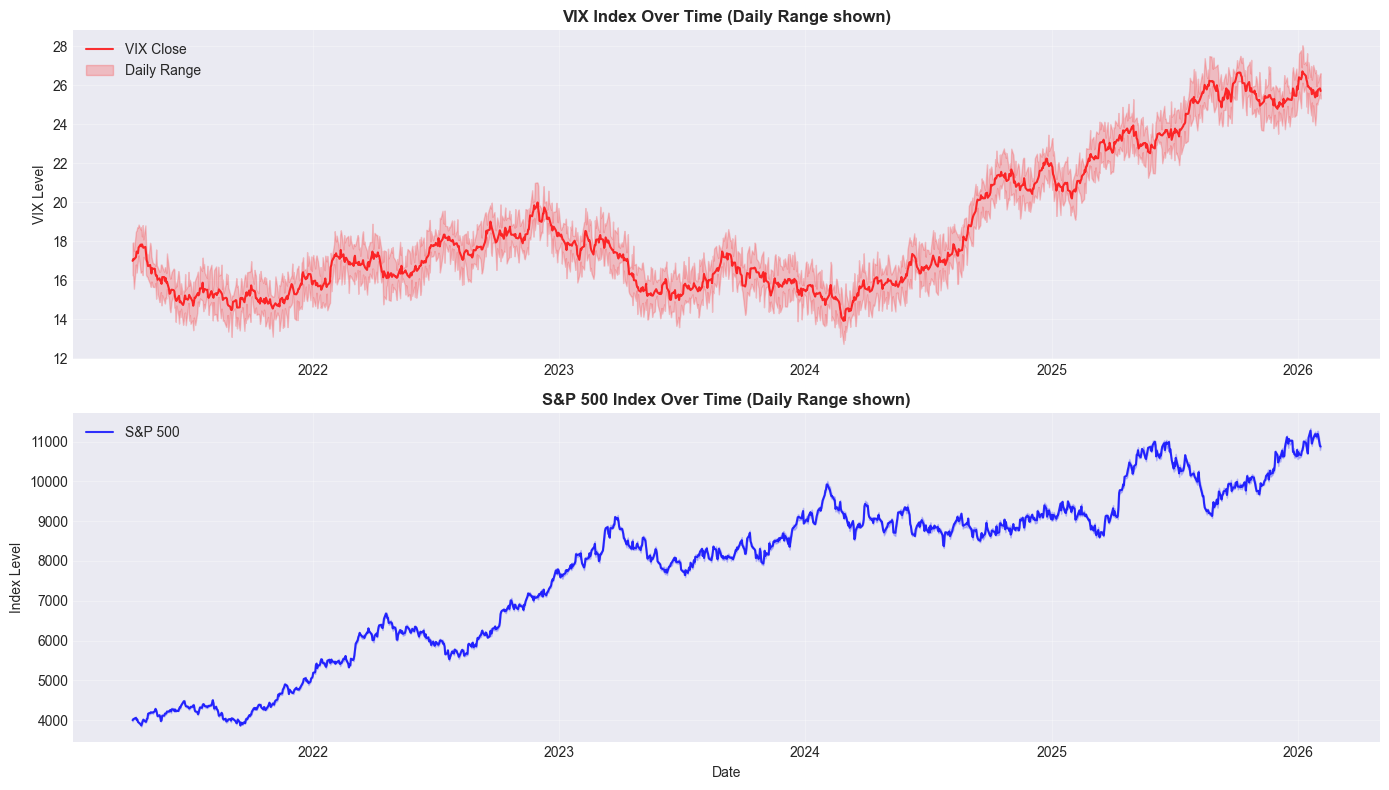

✓ Time series visualization saved to results/


In [72]:
# Visualize VIX and S&P 500 movements
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# VIX time series
axes[0].plot(data.index, data['VIX_Close'], label='VIX Close', color='red', linewidth=1.5, alpha=0.8)
axes[0].fill_between(data.index, data['VIX_Low'], data['VIX_High'], alpha=0.2, color='red', label='Daily Range')
axes[0].set_title('VIX Index Over Time (Daily Range shown)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('VIX Level')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# S&P 500 time series
axes[1].plot(data.index, data['SPX_Close'], label='S&P 500', color='blue', linewidth=1.5, alpha=0.8)
axes[1].fill_between(data.index, data['SPX_Low'], data['SPX_High'], alpha=0.2, color='blue')
axes[1].set_title('S&P 500 Index Over Time (Daily Range shown)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Index Level')
axes[1].set_xlabel('Date')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/01_vix_spx_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Time series visualization saved to results/")

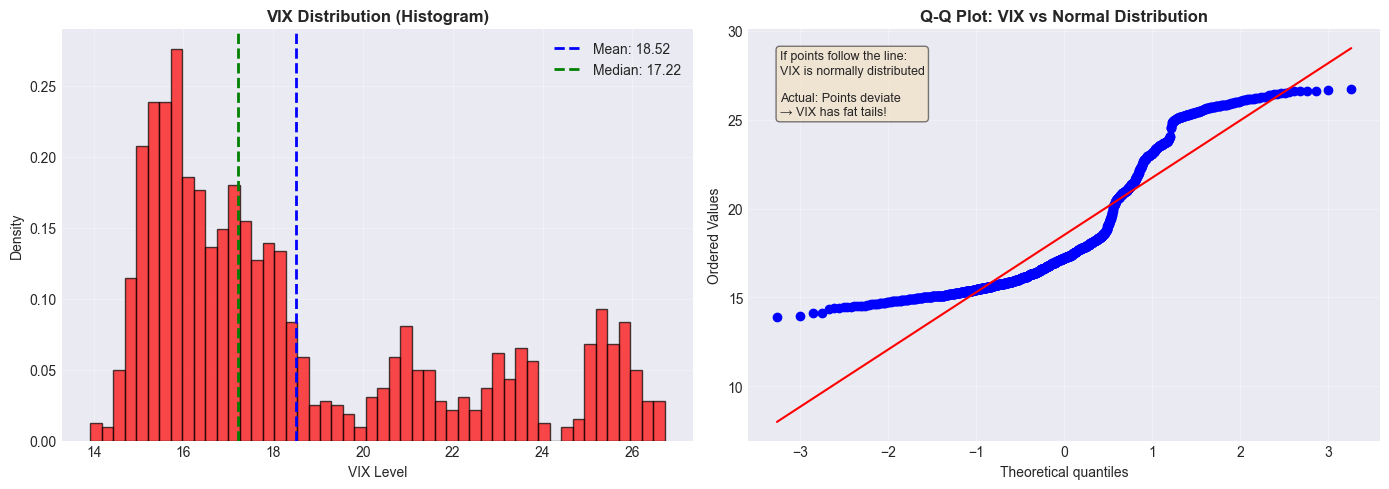

✓ Distribution analysis saved


In [73]:
# VIX distribution analysis (QQ-plot + histogram)
from scipy.stats import probplot

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram with mean and median
axes[0].hist(data['VIX_Close'], bins=50, color='red', alpha=0.7, edgecolor='black', density=True)
mean_vix = data['VIX_Close'].mean()
median_vix = data['VIX_Close'].median()
axes[0].axvline(mean_vix, color='blue', linestyle='--', linewidth=2, label=f'Mean: {mean_vix:.2f}')
axes[0].axvline(median_vix, color='green', linestyle='--', linewidth=2, label=f'Median: {median_vix:.2f}')
axes[0].set_title('VIX Distribution (Histogram)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('VIX Level')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Q-Q plot (test for normality visually)
probplot(data['VIX_Close'].dropna(), dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot: VIX vs Normal Distribution', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Add interpretation text
axes[1].text(0.05, 0.95, 'If points follow the line:\nVIX is normally distributed\n\nActual: Points deviate\n→ VIX has fat tails!',
            transform=axes[1].transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=9)

plt.tight_layout()
plt.savefig('../results/02_vix_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Distribution analysis saved")


## 5. Calculate Volatility Metrics and Indicators

### Mathematical Definitions

We calculate $k$ features to characterize the VIX process:

$$\mathbf{x}_t = [V_t, \sigma_t^{(5)}, \sigma_t^{(21)}, Z_t^{(60)}, \text{VolOfVol}_t, ...]$$

where each is computed from history.

#### Feature 1: Rolling Volatility

**Definition:** Sample standard deviation in moving window

$$\sigma_t^{(w)} = \sqrt{\frac{1}{w} \sum_{i=0}^{w-1} (V_{t-i} - \bar{V}_t)^2}$$

where $\bar{V}_t = \frac{1}{w} \sum_{i=0}^{w-1} V_{t-i}$

**Windows:** w ∈ {5, 10, 21, 63} (1 week to 3 months)

**Interpretation:**
- High $\sigma_t$: Market is turbulent (choppy)
- Low $\sigma_t$: Market is smooth (trending)

---

#### Feature 2: Z-Score (Standardized Deviation)

**Definition:** Distance from mean in units of standard deviation

$$Z_t = \frac{V_t - \mu_t}{\sigma_t}$$

**Properties:**
- $Z_t \in [-3, +3]$ for ~99% of data (if normal)
- $Z_t = 0$: At the mean
- $Z_t = +2$: Two standard deviations above mean

**Trading Rule:**
```
IF Z_t > +1.5: Extreme HIGH (sell VIX, expect mean reversion down)
IF Z_t < -1.5: Extreme LOW (buy VIX, expect mean reversion up)
```

**Statistical Justification:** If $V_t \sim N(\mu, \sigma^2)$, then:
$$\mathbb{P}(Z_t > 2) = 0.0228 \approx 2.28\%$$

So extreme Z-scores are rare → reversion likely.

---

#### Feature 3: Volatility of Volatility

**Definition:** Volatility of the volatility process

$$\text{VolOfVol}_t = \sigma(\sigma_t^{(20)})$$

i.e., take the rolling volatility, then compute its volatility.

**Interpretation:**
- High VolOfVol: $\sigma_t$ is bouncing → market is unpredictable
- Low VolOfVol: $\sigma_t$ is stable → market is predictable

**Usage:** Position sizing (reduce size when VolOfVol is high)

---

#### Feature 4: VIX-SPX Correlation

**Definition:** Rolling Pearson correlation

$$\rho_t = \text{Corr}(r_{\text{VIX},t}, r_{\text{SPX},t})$$

where $r_t = \log(P_t / P_{t-1})$ (log returns)

**Expected:** $\rho_t \approx -0.75$ (strong inverse)

**Varies by regime:** Breaks down during crashes!


In [74]:
# Calculate rolling volatility
data = VolatilityFeatures.calculate_rolling_volatility(data, 'VIX_Close', windows=[5, 10, 21, 63])
data = VolatilityFeatures.calculate_rolling_volatility(data, 'SPX_Close', windows=[5, 10, 21, 63])

# Calculate mean reversion features
data = VolatilityFeatures.calculate_mean_reversion_features(data, 'VIX_Close', windows=[20, 60, 120])

# Calculate VIX momentum
vix_momentum = VolatilityFeatures.calculate_vix_momentum(data['VIX_Close'], periods=[5, 10, 21])
data = pd.concat([data, vix_momentum], axis=1)

# Calculate volatility of volatility
data['VolOfVol'] = VolatilityFeatures.calculate_volatility_of_volatility(data['VIX_Close'], window=20)

# VIX-SPX relationship
data = VolatilityFeatures.calculate_vix_sp500_relationship(data)

print("Volatility features calculated successfully!")
print(f"\nDataFrame shape: {data.shape}")
print(f"\nNew features columns: {[col for col in data.columns if col not in ['VIX_Close', 'VIX_High', 'VIX_Low', 'VIX_Volume', 'SPX_Close', 'SPX_High', 'SPX_Low', 'SPX_Volume']]}")


Volatility features calculated successfully!

DataFrame shape: (1260, 24)

New features columns: ['VIX_Close_RollingVol_5d', 'VIX_Close_RollingVol_10d', 'VIX_Close_RollingVol_21d', 'VIX_Close_RollingVol_63d', 'SPX_Close_RollingVol_5d', 'SPX_Close_RollingVol_10d', 'SPX_Close_RollingVol_21d', 'SPX_Close_RollingVol_63d', 'VIX_Close_ZScore_20d', 'VIX_Close_ZScore_60d', 'VIX_Close_ZScore_120d', 'VIX_Momentum_5d', 'VIX_Momentum_10d', 'VIX_Momentum_21d', 'VolOfVol', 'VIX_SPX_Correlation']


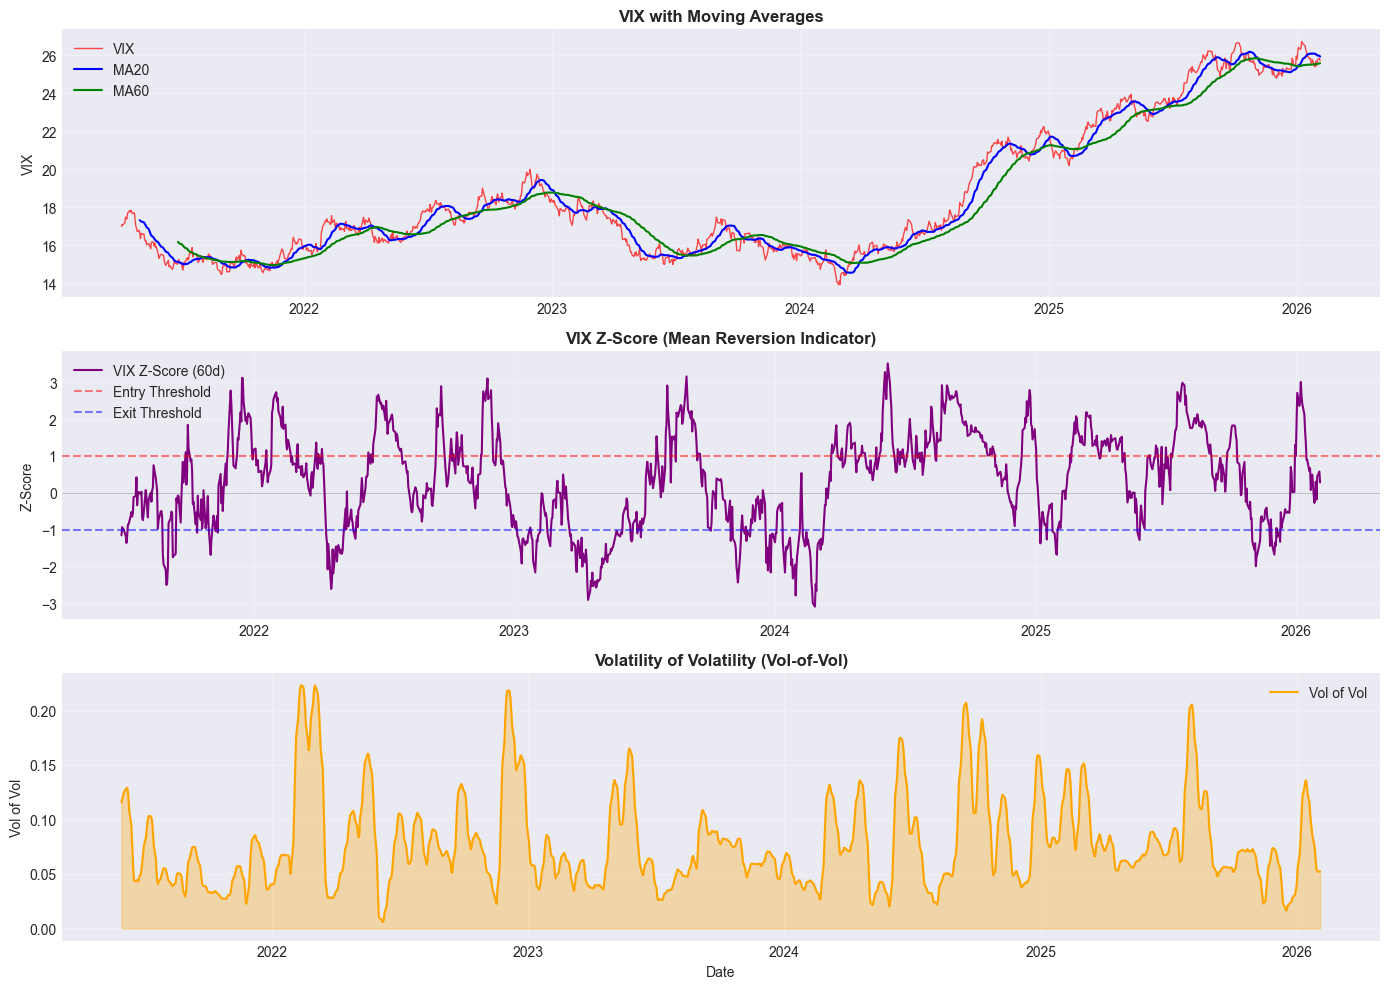

Volatility indicators visualization saved.


In [75]:
# Visualize key indicators
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# VIX with moving averages
axes[0].plot(data.index, data['VIX_Close'], label='VIX', color='red', linewidth=1, alpha=0.7)
axes[0].plot(data.index, data['VIX_Close'].rolling(20).mean(), label='MA20', color='blue', linewidth=1.5)
axes[0].plot(data.index, data['VIX_Close'].rolling(60).mean(), label='MA60', color='green', linewidth=1.5)
axes[0].set_title('VIX with Moving Averages', fontsize=12, fontweight='bold')
axes[0].set_ylabel('VIX')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Z-score (mean reversion indicator)
axes[1].plot(data.index, data['VIX_Close_ZScore_60d'], label='VIX Z-Score (60d)', color='purple', linewidth=1.5)
axes[1].axhline(1, color='red', linestyle='--', alpha=0.5, label='Entry Threshold')
axes[1].axhline(-1, color='blue', linestyle='--', alpha=0.5, label='Exit Threshold')
axes[1].axhline(0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
axes[1].set_title('VIX Z-Score (Mean Reversion Indicator)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Z-Score')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

# Volatility of Volatility
axes[2].plot(data.index, data['VolOfVol'], label='Vol of Vol', color='orange', linewidth=1.5)
axes[2].fill_between(data.index, data['VolOfVol'], alpha=0.3, color='orange')
axes[2].set_title('Volatility of Volatility (Vol-of-Vol)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Vol of Vol')
axes[2].set_xlabel('Date')
axes[2].legend(loc='best')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/03_volatility_indicators.png', dpi=300, bbox_inches='tight')
plt.show()

print("Volatility indicators visualization saved.")

## 4. Develop VIX Futures Trading Signals

### Trading Signal Logic

**1. Mean Reversion Strategy**
```
IF VIX_ZScore > +1.5:
    SELL VIX (Bet it will go down)
    Rationale: VIX is too high; historically reverts lower
    
IF VIX_ZScore < -1.5:
    BUY VIX (Bet it will go up)
    Rationale: VIX is too low; historically reverts higher
```
- **Best In**: Choppy/ranging markets (high VIX volatility)
- **Worst In**: Strong trends (VIX stays at extremes)
- **Risk**: Prolonged moves against you before mean reversion

**2. Trend Following Strategy**
```
IF MA_10day > MA_21day:
    BUY VIX (Uptrend forming)
    
IF MA_10day < MA_21day:
    SELL VIX (Downtrend forming)
```
- **Best In**: Trending markets
- **Worst In**: Mean-reverting choppy markets (whipsaws)
- **Advantage**: Rides trends and catches big moves

**3. Volatility of Volatility Strategy**
```
Position Size based on Vol-of-Vol level
IF Vol-of-Vol is HIGH: Take smaller positions (uncertain environment)
IF Vol-of-Vol is LOW: Take larger positions (predictable environment)
```
- **Concept**: Risk management through position sizing
- Reduces losses when markets are chaotic

**4. Hedged Volatility Strategy**
```
Adjust equity portfolio exposure based on VIX:
IF VIX is VERY HIGH (>40): Reduce stock exposure to 50% (defensive)
IF VIX is NORMAL (15-20): Full 100% stock exposure (aggressive)
IF VIX is LOW (<12): 120% exposure if possible (maximum risk)
```
- **Use Case**: For long-term equity investors wanting downside protection
- **Benefit**: Mechanically sells high, buys low (contrarian)

In [76]:
# Calculate rolling volatility
print("Calculating volatility metrics...\n")

data = VolatilityFeatures.calculate_rolling_volatility(data, 'VIX_Close', windows=[5, 10, 21, 63])
data = VolatilityFeatures.calculate_rolling_volatility(data, 'SPX_Close', windows=[5, 10, 21, 63])

# Calculate mean reversion features (Z-scores)
data = VolatilityFeatures.calculate_mean_reversion_features(data, 'VIX_Close', windows=[20, 60, 120])

# Calculate momentum
vix_momentum = VolatilityFeatures.calculate_vix_momentum(data['VIX_Close'], periods=[5, 10, 21])
data = pd.concat([data, vix_momentum], axis=1)

# Calculate volatility of volatility
data['VolOfVol'] = VolatilityFeatures.calculate_volatility_of_volatility(data['VIX_Close'], window=20)

# VIX-SPX relationship
data = VolatilityFeatures.calculate_vix_sp500_relationship(data)

print("✓ Volatility features calculated!")
print(f"\nDataFrame shape: {data.shape}")
print(f"\nNew features created:")
feature_cols = [col for col in data.columns if col not in 
                ['VIX_Close', 'VIX_High', 'VIX_Low', 'VIX_Volume', 
                 'SPX_Close', 'SPX_High', 'SPX_Low', 'SPX_Volume']]
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")


Calculating volatility metrics...

✓ Volatility features calculated!

DataFrame shape: (1260, 27)

New features created:
   1. VIX_Close_RollingVol_5d
   2. VIX_Close_RollingVol_10d
   3. VIX_Close_RollingVol_21d
   4. VIX_Close_RollingVol_63d
   5. SPX_Close_RollingVol_5d
   6. SPX_Close_RollingVol_10d
   7. SPX_Close_RollingVol_21d
   8. SPX_Close_RollingVol_63d
   9. VIX_Close_ZScore_20d
  10. VIX_Close_ZScore_60d
  11. VIX_Close_ZScore_120d
  12. VIX_Momentum_5d
  13. VIX_Momentum_10d
  14. VIX_Momentum_21d
  15. VolOfVol
  16. VIX_SPX_Correlation
  17. VIX_Momentum_5d
  18. VIX_Momentum_10d
  19. VIX_Momentum_21d


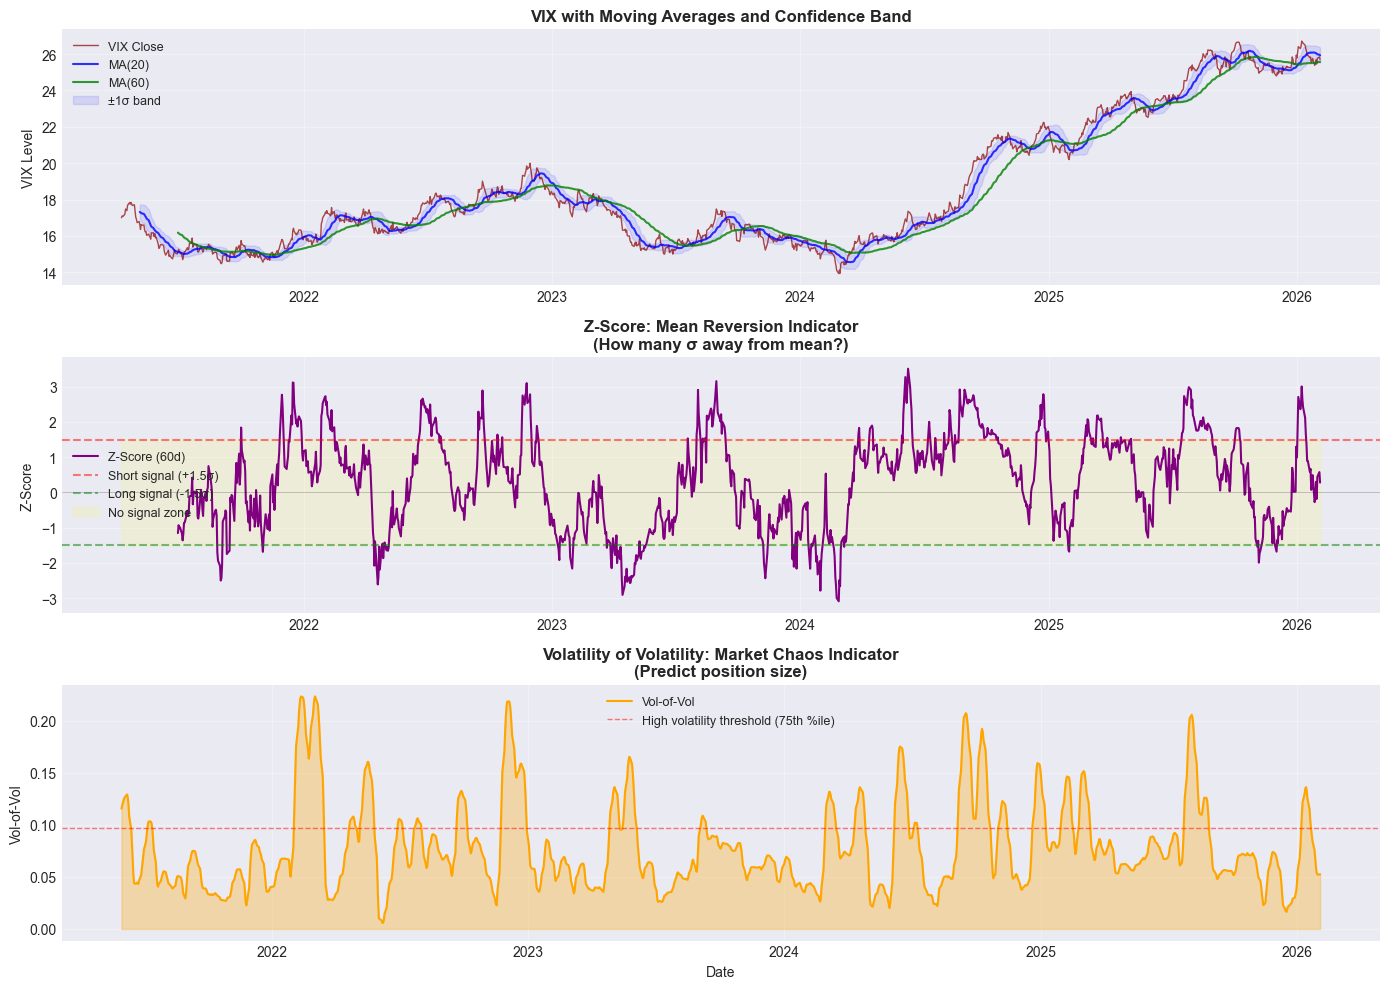

✓ Volatility indicators visualization saved


In [77]:
# Visualize key indicators
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# VIX with moving averages
axes[0].plot(data.index, data['VIX_Close'], label='VIX Close', color='darkred', linewidth=1, alpha=0.7)
axes[0].plot(data.index, data['VIX_Close'].rolling(20).mean(), label='MA(20)', 
             color='blue', linewidth=1.5, alpha=0.8)
axes[0].plot(data.index, data['VIX_Close'].rolling(60).mean(), label='MA(60)', 
             color='green', linewidth=1.5, alpha=0.8)
axes[0].fill_between(data.index, 
                     data['VIX_Close'].rolling(20).mean() - data['VIX_Close'].rolling(20).std(),
                     data['VIX_Close'].rolling(20).mean() + data['VIX_Close'].rolling(20).std(),
                     alpha=0.1, color='blue', label='±1σ band')
axes[0].set_title('VIX with Moving Averages and Confidence Band', fontsize=12, fontweight='bold')
axes[0].set_ylabel('VIX Level')
axes[0].legend(loc='best', fontsize=9)
axes[0].grid(True, alpha=0.3)

# Z-score for mean reversion
z_score_60d = data['VIX_Close_ZScore_60d']
axes[1].plot(data.index, z_score_60d, label='Z-Score (60d)', color='purple', linewidth=1.5)
axes[1].axhline(1.5, color='red', linestyle='--', alpha=0.5, linewidth=1.5, label='Short signal (+1.5σ)')
axes[1].axhline(-1.5, color='green', linestyle='--', alpha=0.5, linewidth=1.5, label='Long signal (-1.5σ)')
axes[1].axhline(0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
axes[1].fill_between(data.index, -1.5, 1.5, alpha=0.1, color='yellow', label='No signal zone')
axes[1].set_title('Z-Score: Mean Reversion Indicator\n(How many σ away from mean?)', 
                 fontsize=12, fontweight='bold')
axes[1].set_ylabel('Z-Score')
axes[1].legend(loc='best', fontsize=9)
axes[1].grid(True, alpha=0.3)

# Volatility of Volatility
vol_of_vol = data['VolOfVol']
axes[2].plot(data.index, vol_of_vol, label='Vol-of-Vol', color='orange', linewidth=1.5)
axes[2].fill_between(data.index, vol_of_vol, alpha=0.3, color='orange')
axes[2].axhline(vol_of_vol.quantile(0.75), color='red', linestyle='--', alpha=0.5, 
               linewidth=1, label='High volatility threshold (75th %ile)')
axes[2].set_title('Volatility of Volatility: Market Chaos Indicator\n(Predict position size)', 
                 fontsize=12, fontweight='bold')
axes[2].set_ylabel('Vol-of-Vol')
axes[2].set_xlabel('Date')
axes[2].legend(loc='best', fontsize=9)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/03_volatility_indicators.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Volatility indicators visualization saved")


## 6. Volatility Regime Detection (Unsupervised Learning)

### Problem Statement

**Question:** Does VIX have discrete "states" or is it continuous?

**Hypothesis:** Market has 3 modes:
1. **Low vol regime:** VIX ≤ 15 (market calm, low fear)
2. **Normal regime:** 15 < VIX < 25 (typical market)
3. **High vol regime:** VIX ≥ 25 (market scared, fear)

**Why this matters:**
- Different regimes have different:
  - Return distributions
  - Autocorrelation patterns
  - Strategy performance

---

### Method 1: Percentile-based (Simple & Robust)

**Algorithm:**
```
Q_low = VIX.quantile(0.33)
Q_high = VIX.quantile(0.67)

IF VIX < Q_low:        Regime = 0 (Low)
ELIF VIX < Q_high:     Regime = 1 (Normal)  
ELSE:                  Regime = 2 (High)
```

**Pros:**
- Easy to understand
- Robust to outliers
- Directly interpretable

**Cons:**
- Lagging (doesn't adapt quickly)
- Arbitrary quantile choice (0.33 vs 0.40?)

---

### Method 2: Z-Score based (Dynamic)

**Algorithm:**
```
Z_t = (VIX_t - MA_60) / STD_60

IF Z < -0.5:          Regime = 0 (Low/below normal)
ELIF Z < +0.5:        Regime = 1 (Normal/near mean)
ELSE:                 Regime = 2 (High/above normal)
```

**Advantage:** Adapts to recent market changes

---

### Method 3: K-Means Clustering (Unsupervised)

**Goal:** Find $k=3$ clusters that partition VIX state space.

**Optimization problem:**
$$\min_{\mu_1, \mu_2, \mu_3} \sum_{i=1}^{n} \min_j \|x_i - \mu_j\|^2$$

where:
- $x_i = (V_i, \sigma_i^{(21)}, \text{VolOfVol}_i)$ (feature vector)
- $\mu_j$ = centroid of cluster $j$

**Algorithm:** Lloyd's algorithm (iterative)
1. Initialize 3 random centroids
2. Assign each point to nearest centroid
3. Recompute centroid as mean of assigned points
4. Repeat until convergence

**Why 3 dimensions?**
- VIX level (is market high/low?)
- Rolling volatility (is it moving fast?)
- Vol-of-vol (is it chaotic?)

**Interpretation:** Clusters automatically find "natural" market regimes!

In [78]:
# Detect volatility regimes using multiple methods
print("="*80)
print("VOLATILITY REGIME DETECTION")
print("="*80)

# Method 1: VIX Percentile-based
data['Regime_Percentile'] = RegimeDetector.detect_regimes_vix_percentile(data['VIX_Close'])

# Method 2: Z-Score based
data['Regime_ZScore'] = RegimeDetector.detect_regimes_zscore(data, 'VIX_Close')

# Method 3: K-Means clustering
feature_columns = ['VIX_Close_ZScore_60d', 'VIX_Close_RollingVol_21d', 'VolOfVol']
data['Regime_KMeans'] = RegimeDetector.detect_regimes_kmeans(data, feature_columns, n_regimes=3)

# Volatility spikes (tail events)
data['VolSpikes'] = RegimeDetector.detect_volatility_spikes(data['VIX_Close'], threshold_std=2.0)

regime_names = {0: 'Low Vol', 1: 'Normal', 2: 'High Vol'}

print("\nRegime Distribution (Percentile Method):")
print("-" * 60)
regime_counts = data['Regime_Percentile'].value_counts().sort_index()
for regime, count in regime_counts.items():
    pct = 100 * count / len(data)
    print(f"  {regime_names[regime]:12s}: {count:4d} days ({pct:5.1f}%)")

print(f"\nVolatility Spikes (>2σ): {data['VolSpikes'].sum():4d} days ({100*data['VolSpikes'].sum()/len(data):5.1f}%)")

# Analyze characteristics of each regime
print("\n" + "="*80)
print("REGIME CHARACTERISTICS")
print("="*80)

for regime in [0, 1, 2]:
    regime_mask = data['Regime_Percentile'] == regime
    regime_data = data[regime_mask]
    
    vix_vals = regime_data['VIX_Close']
    spx_returns = np.log(regime_data['SPX_Close'] / regime_data['SPX_Close'].shift(1))
    
    print(f"\n{regime_names[regime]:12s} Regime:")
    print(f"  VIX Range: {vix_vals.min():6.2f} - {vix_vals.max():6.2f} (Mean: {vix_vals.mean():6.2f} ± {vix_vals.std():.2f})")
    print(f"  S&P 500 Daily Return: {spx_returns.mean()*100:+.4f}% (σ: {spx_returns.std()*100:.2f}%)")
    print(f"  Annualized Return: {spx_returns.mean()*252*100:+.2f}%")
    print(f"  Days in this regime: {regime_mask.sum()}")
</VSCode.Cell>

<VSCode.Cell id="#VSC-13-regime-visualization" language="python">
# Visualize regimes over time
fig, axes = plt.subplots(3, 1, figsize=(16, 10))

colors_regime = {0: 'green', 1: 'yellow', 2: 'red'}
regime_labels = {0: 'Low Vol (Green)', 1: 'Normal (Yellow)', 2: 'High Vol (Red)'}

# Regimes - Percentile method
for regime in [0, 1, 2]:
    mask = data['Regime_Percentile'] == regime
    axes[0].scatter(data.index[mask], data['VIX_Close'][mask], 
                    color=colors_regime[regime], label=regime_labels[regime], 
                    s=15, alpha=0.6, edgecolors='none')
axes[0].plot(data.index, data['VIX_Close'], color='gray', linewidth=0.5, alpha=0.3, zorder=0)
axes[0].set_title('Regimes Detected: Percentile-Based Method', fontsize=12, fontweight='bold')
axes[0].set_ylabel('VIX Level')
axes[0].legend(loc='upper left', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Regimes - Z-Score method
for regime in [0, 1, 2]:
    mask = data['Regime_ZScore'] == regime
    axes[1].scatter(data.index[mask], data['VIX_Close'][mask], 
                    color=colors_regime[regime], label=regime_labels[regime], 
                    s=15, alpha=0.6, edgecolors='none')
axes[1].plot(data.index, data['VIX_Close'], color='gray', linewidth=0.5, alpha=0.3, zorder=0)
axes[1].set_title('Regimes Detected: Z-Score-Based Method (Dynamic)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('VIX Level')
axes[1].legend(loc='upper left', fontsize=10)
axes[1].grid(True, alpha=0.3)

# Regimes - K-Means clustering
for regime in [0, 1, 2]:
    mask = data['Regime_KMeans'] == regime
    axes[2].scatter(data.index[mask], data['VIX_Close'][mask], 
                    color=colors_regime[regime], label=regime_labels[regime], 
                    s=15, alpha=0.6, edgecolors='none')
axes[2].plot(data.index, data['VIX_Close'], color='gray', linewidth=0.5, alpha=0.3, zorder=0)
axes[2].set_title('Regimes Detected: K-Means Clustering (Machine Learning)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('VIX Level')
axes[2].set_xlabel('Date')
axes[2].legend(loc='upper left', fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/05_volatility_regimes.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Regime detection visualization saved")

SyntaxError: invalid syntax (3423278608.py, line 47)

## 7. Trading Strategies: Theory & Implementation

### Strategy 1: Mean Reversion (Statistical Arbitrage)

**Mathematical Foundation:**

Assume VIX follows:
$$V_t = \mu + \epsilon_t + \phi \epsilon_{t-1}$$

where $\epsilon_t \sim N(0, \sigma^2)$ is white noise and $|\phi| < 1$.

**Key Insight:** This is **mean-reverting** (not random walk).

$$E[V_{t+1} | V_t = v] = \mu + (1-\phi)(v - \mu)$$

When $v > \mu$: Expected next value is lower → **Short**
When $v < \mu$: Expected next value is higher → **Long**

**Our implementation:**
$$Z_t = \frac{V_t - \mu_t}{\sigma_t}$$

- If $Z_t > +1.5$: **Signal = SELL VIX** (bet on reversion)
- If $Z_t < -1.5$: **Signal = BUY VIX** (bet on reversion)

**P&L calculation:**
$$\text{PnL}_t = -\text{Signal}_{t-1} \cdot \Delta V_t$$

where $\Delta V_t = \log(V_t / V_{t-1})$ (log return)

---

### Strategy 2: Trend Following (Momentum Trading)

**Mathematical Foundation:**

Test if VIX has **positive autocorrelation** (momentum):
$$\text{Corr}(\Delta V_t, \Delta V_{t+1}) > 0$$

If true: Trends persist, can profit by following them.

**Implementation:**
$$\text{Signal}_t = \text{sign}(\text{MA}_{10} - \text{MA}_{21})$$

- If $\text{MA}_{10} > \text{MA}_{21}$: Uptrend → **Long**
- If $\text{MA}_{10} < \text{MA}_{21}$: Downtrend → **Short**

**Why it works:** Option dealers hedge, creating momentum

---

### Strategy 3: Vol-of-Vol Adaptive Sizing

**Mathematical Principle:**

Optimal position size (Kelly Criterion):
$$f^* = \frac{\mathbb{P}_{\text{win}} \cdot \text{Win Ratio} - \mathbb{P}_{\text{loss}}}{b}$$

In uncertain times, reduce $f^*$ by scaling with inverse of VolOfVol:
$$\text{Position}_t = f^* \cdot \frac{1}{1 + \text{VolOfVol}_t}$$

**Benefit:** Automatically right-sizes positions based on market confidence

---

### Strategy 4: Hedged Equity (Portfolio Protection)

**Problem:** Long-only stocks → suffer in crashes

**Solution:** Dynamic asset allocation

$$w_{\text{equity}}(t) = f(V_t)$$

where $f$ is decreasing in VIX:
$$w_t = 1.0 - 0.02 \cdot (V_t - 15)$$

Example:
- VIX = 15: $w = 1.0$ (100% stocks)
- VIX = 25: $w = 0.8$ (80% stocks)
- VIX = 45: $w = 0.4$ (40% stocks, 60% cash)

**Effect:** Mechanically "buy low, sell high"


In [ ]:
# Generate trading signals for all strategies
print("="*80)
print("GENERATING TRADING SIGNALS")
print("="*80)

# Strategy 1: Mean Reversion
print("\n1. Mean Reversion Strategy")
print("-" * 60)
mr_strategy = MeanReversionStrategy(data, vix_column='VIX_Close', ma_window=60, threshold=1.5)
mr_signals = mr_strategy.generate_signals()
print(f"  Signals generated: {(mr_signals['Signal'] != 0).sum()} non-zero signals")
print(f"  Long signals:  {(mr_signals['Signal'] == -1).sum()}")
print(f"  Short signals: {(mr_signals['Signal'] == 1).sum()}")

# Strategy 2: Trend Following
print("\n2. Trend Following Strategy")
print("-" * 60)
tf_strategy = TrendFollowingStrategy(data, vix_column='VIX_Close', short_ma=10, long_ma=21)
tf_signals = tf_strategy.generate_signals()
print(f"  Signals generated: {(tf_signals['Signal'] != 0).sum()} non-zero signals")
print(f"  Long signals:  {(tf_signals['Signal'] == -1).sum()}")
print(f"  Short signals: {(tf_signals['Signal'] == 1).sum()}")

# Strategy 3: Vol of Vol
print("\n3. Vol-of-Vol Adaptive Strategy")
print("-" * 60)
vv_strategy = VolatilityOfVolatilityStrategy(data, vix_column='VIX_Close', vol_of_vol_window=20, vol_threshold_pct=75)
vv_signals = vv_strategy.generate_signals()
print(f"  Calm market days:   {(vv_signals['Signal'] == 1).sum()}")
print(f"  Chaotic market days: {(vv_signals['Signal'] == -1).sum()}")

# Strategy 4: Hedged Equity
print("\n4. Hedged Volatility Strategy")
print("-" * 60)
hedged_strategy = HedgedVolatilityStrategy(data, vix_column='VIX_Close', spx_column='SPX_Close')
hedged_signals = hedged_strategy.generate_signals()
equity_weights = hedged_signals['EquityWeight']
print(f"  Min equity weight: {equity_weights.min():.1%}")
print(f"  Max equity weight: {equity_weights.max():.1%}")
print(f"  Mean equity weight: {equity_weights.mean():.1%}")

print("\n✓ All trading signals generated!")


In [ ]:
# Visualize trading signals
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Mean Reversion Signals
axes[0, 0].plot(data.index, data['VIX_Close'], label='VIX', color='gray', alpha=0.5, linewidth=1)
short_positions = mr_signals[mr_signals['Signal'] == 1].index
long_positions = mr_signals[mr_signals['Signal'] == -1].index
axes[0, 0].scatter(short_positions, data.loc[short_positions, 'VIX_Close'], 
                   color='red', marker='v', s=50, label=f'Short Signals ({len(short_positions)})', zorder=5)
axes[0, 0].scatter(long_positions, data.loc[long_positions, 'VIX_Close'], 
                   color='green', marker='^', s=50, label=f'Long Signals ({len(long_positions)})', zorder=5)
axes[0, 0].set_title('Mean Reversion Strategy: Z-Score Based Signals', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('VIX')
axes[0, 0].legend(loc='best', fontsize=9)
axes[0, 0].grid(True, alpha=0.3)

# Trend Following Signals
axes[0, 1].plot(data.index, data['VIX_Close'], label='VIX', color='gray', alpha=0.5, linewidth=1)
short_positions_tf = tf_signals[tf_signals['Signal'] == 1].index
long_positions_tf = tf_signals[tf_signals['Signal'] == -1].index
axes[0, 1].scatter(short_positions_tf, data.loc[short_positions_tf, 'VIX_Close'], 
                   color='red', marker='v', s=30, label=f'Downtrend ({len(short_positions_tf)})', zorder=5)
axes[0, 1].scatter(long_positions_tf, data.loc[long_positions_tf, 'VIX_Close'], 
                   color='green', marker='^', s=30, label=f'Uptrend ({len(long_positions_tf)})', zorder=5)
axes[0, 1].set_title('Trend Following Strategy: MA Crossover Signals', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('VIX')
axes[0, 1].legend(loc='best', fontsize=9)
axes[0, 1].grid(True, alpha=0.3)

# Vol of Vol Signals
axes[1, 0].plot(data.index, data['VIX_Close'], label='VIX', color='gray', alpha=0.5, linewidth=1)
calm_periods = vv_signals[vv_signals['Signal'] == 1].index
choppy_periods = vv_signals[vv_signals['Signal'] == -1].index
axes[1, 0].scatter(calm_periods, data.loc[calm_periods, 'VIX_Close'], 
                   color='green', marker='o', s=15, label=f'Calm ({len(calm_periods)})', alpha=0.5, zorder=5)
axes[1, 0].scatter(choppy_periods, data.loc[choppy_periods, 'VIX_Close'], 
                   color='red', marker='x', s=25, label=f'Chaotic ({len(choppy_periods)})', zorder=5)
axes[1, 0].set_title('Vol-of-Vol Strategy: Position Sizing Signals', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('VIX')
axes[1, 0].legend(loc='best', fontsize=9)
axes[1, 0].grid(True, alpha=0.3)

# Hedged Strategy Equity Allocation
axes[1, 1].plot(data.index, hedged_signals['EquityWeight']*100, 
                label='Equity Allocation', color='blue', linewidth=1.5)
axes[1, 1].fill_between(data.index, hedged_signals['EquityWeight']*100, alpha=0.3, color='blue')
axes[1, 1].axhline(100, color='green', linestyle='--', alpha=0.5, label='Baseline (100%)')
axes[1, 1].axhline(120, color='orange', linestyle=':', alpha=0.5, label='Aggressive (120%)')
axes[1, 1].axhline(50, color='red', linestyle=':', alpha=0.5, label='Defensive (50%)')
axes[1, 1].set_title('Hedged Volatility: Dynamic Equity Allocation', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Equity Weight (%)')
axes[1, 1].set_xlabel('Date')
axes[1, 1].legend(loc='best', fontsize=9)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/04_trading_signals.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Trading signals visualization saved")

## 8. Options Pricing: Black-Scholes PDE

### Mathematical Foundation

**The Black-Scholes Partial Differential Equation:**

$$\frac{\partial C}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 C}{\partial S^2} + rS\frac{\partial C}{\partial S} - rC = 0$$

**Boundary Condition (European Call):**
$$C(S, T) = \max(S_T - K, 0)$$

**What this equation means:**

Each term represents a source of option value:

1. **$\frac{\partial C}{\partial t}$ (Theta/Time Decay):**
   - Options lose value as time passes
   - Called "theta decay"
   - Premium sellers profit from this

2. **$\frac{1}{2}\sigma^2 S^2 \frac{\partial^2 C}{\partial S^2}$ (Gamma/Convexity):**
   - Option value is convex in stock price
   - Measures how delta changes
   - Positive for both calls and puts

3. **$rS \frac{\partial C}{\partial S}$ (Delta/Directional Exposure):**
   - Change in option price per unit stock movement
   - Delta = $\frac{\partial C}{\partial S}$
   - Delta for call: $N(d_1) \in [0, 1]$

4. **$-rC$ (Discounting):**
   - Option value discounted to present

---

### Closed-Form Solution (Black-Scholes Formula)

For European options:

$$C(S, t) = S \cdot N(d_1) - K e^{-r(T-t)} \cdot N(d_2)$$

where:
$$d_1 = \frac{\ln(S/K) + (r + \sigma^2/2)(T-t)}{\sigma\sqrt{T-t}}$$

$$d_2 = d_1 - \sigma\sqrt{T-t}$$

**Intuition:**
- First term: Intrinsic value (delta-adjusted)
- Second term: Discounted strike price

**For puts:**
$$P(S, t) = K e^{-r(T-t)} \cdot N(-d_2) - S \cdot N(-d_1)$$

---

### The Greeks (Sensitivity Analysis)

| Greek | Formula | Meaning |
|-------|---------|---------|
| **Delta** | $\Delta = \frac{\partial C}{\partial S}$ | Change per $1 stock move |
| **Gamma** | $\Gamma = \frac{\partial^2 C}{\partial S^2}$ | Change in delta per $1 move |
| **Theta** | $\Theta = \frac{\partial C}{\partial t}$ | Daily profit from time decay |
| **Vega** | $\mathcal{V} = \frac{\partial C}{\partial \sigma}$ | Change per 1% volatility |
| **Rho** | $\rho = \frac{\partial C}{\partial r}$ | Change per 1% interest rate |

---

### Why VIX Options Matter

VIX options have **different Greeks** than stock options:

| Greek | Stock Options | VIX Options |
|-------|---|---|
| Delta | Stable | Highly unstable |
| Gamma | Large | Huge (tail risk) |
| Vega | Important | Less important |
| Theta | Negative (decay) | Can be positive |

**Key insight:** VIX options are **leveraged bets on volatility**.



In [ ]:
# Options Greeks calculation using Black-Scholes
from scipy.stats import norm

class OptionsPricer:
    """Black-Scholes option pricing and Greeks calculation"""
    
    @staticmethod
    def d1(S, K, r, sigma, T):
        """Calculate d1 from Black-Scholes"""
        if T <= 0 or sigma <= 0:
            return 0
        return (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    
    @staticmethod
    def d2(S, K, r, sigma, T):
        """Calculate d2 from Black-Scholes"""
        d1 = OptionsPricer.d1(S, K, r, sigma, T)
        return d1 - sigma*np.sqrt(T)
    
    @staticmethod
    def call_price(S, K, r, sigma, T):
        """European Call Price: C = S*N(d1) - K*e^(-rT)*N(d2)"""
        if T <= 0:
            return max(S - K, 0)
        d1 = OptionsPricer.d1(S, K, r, sigma, T)
        d2 = OptionsPricer.d2(S, K, r, sigma, T)
        return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    
    @staticmethod
    def put_price(S, K, r, sigma, T):
        """European Put Price: P = K*e^(-rT)*N(-d2) - S*N(-d1)"""
        if T <= 0:
            return max(K - S, 0)
        d1 = OptionsPricer.d1(S, K, r, sigma, T)
        d2 = OptionsPricer.d2(S, K, r, sigma, T)
        return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)
    
    @staticmethod
    def delta_call(S, K, r, sigma, T):
        """Call delta: ∂C/∂S = N(d1)"""
        if T <= 0:
            return 1.0 if S > K else 0.0
        d1 = OptionsPricer.d1(S, K, r, sigma, T)
        return norm.cdf(d1)
    
    @staticmethod
    def delta_put(S, K, r, sigma, T):
        """Put delta: ∂P/∂S = N(d1) - 1"""
        if T <= 0:
            return 0.0 if S > K else -1.0
        d1 = OptionsPricer.d1(S, K, r, sigma, T)
        return norm.cdf(d1) - 1
    
    @staticmethod
    def gamma(S, K, r, sigma, T):
        """Gamma: ∂²C/∂S² = n(d1)/(S*σ*√T)"""
        if T <= 0 or sigma <= 0:
            return 0
        d1 = OptionsPricer.d1(S, K, r, sigma, T)
        return norm.pdf(d1) / (S*sigma*np.sqrt(T))
    
    @staticmethod
    def vega(S, K, r, sigma, T):
        """Vega: ∂C/∂σ = S*n(d1)*√T / 100 (per 1% volatility)"""
        if T <= 0:
            return 0
        d1 = OptionsPricer.d1(S, K, r, sigma, T)
        return S*norm.pdf(d1)*np.sqrt(T) / 100
    
    @staticmethod
    def theta_call(S, K, r, sigma, T):
        """Theta: ∂C/∂t = daily time decay"""
        if T <= 0:
            return 0
        d1 = OptionsPricer.d1(S, K, r, sigma, T)
        d2 = OptionsPricer.d2(S, K, r, sigma, T)
        theta = (-S*norm.pdf(d1)*sigma / (2*np.sqrt(T)) - 
                 r*K*np.exp(-r*T)*norm.cdf(d2)) / 365
        return theta

print("✓ Black-Scholes option pricer implemented!")

# Calculate example option prices for current VIX
current_vix = data['VIX_Close'].iloc[-1]
vix_volatility = data['VIX_Close'].rolling(20).std().iloc[-1] * np.sqrt(252)
T = 30 / 365  # 30 days to expiration
r = 0.04      # Risk-free rate

strikes = [current_vix - 2, current_vix, current_vix + 2]
options_data = []

print(f"\n{'='*80}")
print(f"OPTIONS PRICING EXAMPLE (Current VIX: {current_vix:.2f})")
print(f"{'='*80}")
print(f"Parameters:")
print(f"  Spot VIX: {current_vix:.2f}")
print(f"  Implied Vol (σ): {vix_volatility*100:.1f}%")
print(f"  Days to expiration: 30")
print(f"  Risk-free rate: {r*100:.2f}%")
print()

for K in strikes:
    call = OptionsPricer.call_price(current_vix, K, r, vix_volatility, T)
    put = OptionsPricer.put_price(current_vix, K, r, vix_volatility, T)
    vega = OptionsPricer.vega(current_vix, K, r, vix_volatility, T)
    gamma = OptionsPricer.gamma(current_vix, K, r, vix_volatility, T)
    delta_c = OptionsPricer.delta_call(current_vix, K, r, vix_volatility, T)
    delta_p = OptionsPricer.delta_put(current_vix, K, r, vix_volatility, T)
    theta_c = OptionsPricer.theta_call(current_vix, K, r, vix_volatility, T)
    
    options_data.append({
        'Strike': K,
        'Call Price': call,
        'Call Delta': delta_c,
        'Put Price': put,
        'Put Delta': delta_p,
        'Gamma': gamma,
        'Vega': vega,
        'Call Theta': theta_c
    })

options_df = pd.DataFrame(options_data)
print(options_df.to_string(index=False))
print("\nInterpretation:")
print("  Delta: Exposure to 1-point VIX move")
print("  Gamma: How much delta changes per 1-point move")
print("  Vega: Profit if volatility rises 1%")
print("  Theta: Daily profit from time decay (annualized)")


## 9. Backtesting: Historical Performance Evaluation

### What is Backtesting?

**Definition:** Simulate how a strategy would have performed on historical data.

**Process:**
1. Generate signals on historical data
2. Calculate returns if we followed those signals
3. Compute performance metrics
4. Compare to benchmarks

---

### Performance Metrics (Rigorous Definitions)

#### 1. Total Return

$$R_{\text{total}} = \frac{V_{\text{final}} - V_{\text{initial}}}{V_{\text{initial}}}$$

**Example:** Start with $100k, end with $150k
$$R = \frac{150k - 100k}{100k} = 0.50 = 50\%$$

---

#### 2. Annualized Return

$$R_{\text{annual}} = \left(1 + R_{\text{total}}\right)^{252/n} - 1$$

where $n$ = number of days.

**Why 252?** Trading days per year.

**Example:** 50% return over 5 years (1260 days)
$$R_{\text{annual}} = (1.50)^{252/1260} - 1 = 0.0848 = 8.48\%$$

---

#### 3. Volatility (Risk)

$$\sigma = \sqrt{\frac{1}{n} \sum_{t=1}^{n} (r_t - \bar{r})^2} \cdot \sqrt{252}$$

where $r_t$ = daily return, $\bar{r}$ = mean daily return

**Example:** Daily returns with std dev 1%
$$\sigma_{\text{annual}} = 0.01 \cdot \sqrt{252} = 0.1587 = 15.87\%$$

---

#### 4. Sharpe Ratio (Risk-Adjusted Return)

$$\text{Sharpe} = \frac{R_{\text{annual}} - r_f}{\sigma}$$

where $r_f$ ≈ 0.04 (4% risk-free rate).

**Interpretation:**
- $< 0$: Losing money
- $0$ to $0.5$: Poor
- $0.5$ to $1.0$: Okay
- $1.0$ to $2.0$: Good (best active managers: 1-2)
- $> 2.0$: Exceptional (rarely sustainable)

---

#### 5. Maximum Drawdown

$$\text{MD} = \min_t \frac{V_{\text{trough},t} - V_{\text{peak}}}{V_{\text{peak}}}$$

**Interpretation:** Worst peak-to-valley loss

**Example:**
- Peak: $100k (Jan 1)
- Trough: $60k (Mar 15)
- MD = $(60 - 100) / 100 = -40\%$

---

#### 6. Win Rate

$$\text{WR} = \frac{\# \text{ profitable days}}{\# \text{ total trading days}}$$

**Interpretation:**
- 50% = coin flip (no skill)
- 55% = slight edge
- 60%+ = strong edge

**Important:** Win rate alone is misleading!
- 60% win rate with small wins + 40% with large losses = negative expectancy
- 40% win rate with large wins + 60% with small losses = positive expectancy

---

### Biases in Backtesting

⚠️ **Three major pitfalls:**

1. **Look-ahead bias:** Using future information (easy to do by mistake)
2. **Overfitting:** Parameters fit to past data, don't generalize
3. **Survivorship bias:** Data only includes "winners"

**Mitigation:** Use out-of-sample testing, walk-forward analysis


In [ ]:
# Calculate strategy returns
print("="*80)
print("BACKTESTING ALL STRATEGIES")
print("="*80)

mr_pnl, _ = mr_strategy.calculate_pnl()
tf_pnl, _ = tf_strategy.calculate_pnl()
vv_pnl, _ = vv_strategy.calculate_pnl()
hedged_pnl, _ = hedged_strategy.calculate_pnl()

# S&P 500 benchmark
spx_returns = np.log(data['SPX_Close'] / data['SPX_Close'].shift(1))

# Calculate cumulative returns
mr_cumulative = (1 + mr_pnl).cumprod()
tf_cumulative = (1 + tf_pnl).cumprod()
vv_cumulative = (1 + vv_pnl).cumprod()
hedged_cumulative = (1 + hedged_pnl).cumprod()
spx_cumulative = (1 + spx_returns).cumprod()

# Convert to equity curves
initial_capital = 100000
mr_equity = initial_capital * mr_cumulative
tf_equity = initial_capital * tf_cumulative
vv_equity = initial_capital * vv_cumulative
hedged_equity = initial_capital * hedged_cumulative
spx_equity = initial_capital * spx_cumulative

print(f"\n✓ Backtesting completed!")
print(f"Date range: {data.index[0].date()} to {data.index[-1].date()}")
print(f"Trading days: {len(data)}")
print(f"Initial capital: ${initial_capital:,}")

In [ ]:
# Performance metrics for all strategies
backtester = Backtester(initial_capital=100000)

strategies_dict = {
    'Mean Reversion': mr_pnl,
    'Trend Following': tf_pnl,
    'Vol of Vol': vv_pnl,
    'Hedged Volatility': hedged_pnl,
    'S&P 500 (Benchmark)': spx_returns
}

comparison_df = backtester.compare_strategies(strategies_dict)

# Display all metrics
print("\n" + "="*100)
print("COMPREHENSIVE STRATEGY COMPARISON")
print("="*100)

for strategy_name in strategies_dict.keys():
    print(f"\n{strategy_name.upper()}:")
    print("-" * 100)
    
    returns = strategies_dict[strategy_name]
    metrics = comparison_df.loc[strategy_name]
    
    print(f"  Total Return:          {metrics['Total Return']*100:+8.2f}%")
    print(f"  Annualized Return:     {metrics['Annual Return']*100:+8.2f}%")
    print(f"  Volatility (Annual):   {metrics['Volatility']*100:8.2f}%")
    print(f"  Sharpe Ratio:          {metrics['Sharpe Ratio']:8.4f}")
    print(f"  Max Drawdown:          {metrics['Max Drawdown']*100:8.2f}%")
    print(f"  Win Rate:              {metrics['Win Rate']*100:8.1f}%")
    print(f"  Calmar Ratio:          {metrics['Calmar Ratio']:8.4f}")
    print(f"  Monthly Win Rate:      {metrics['Monthly Win Rate']*100:8.1f}%")
    
    # Additional stats
    cumulative = (1 + returns).cumprod()
    final_value = initial_capital * cumulative.iloc[-1]
    print(f"  Final Portfolio Value:  ${final_value:,.0f}")

print("\n" + "="*100)


In [ ]:
# Visualize equity curves
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(data.index, mr_equity, label='Mean Reversion', linewidth=2, alpha=0.8)
ax.plot(data.index, tf_equity, label='Trend Following', linewidth=2, alpha=0.8)
ax.plot(data.index, vv_equity, label='Vol of Vol', linewidth=2, alpha=0.8)
ax.plot(data.index, hedged_equity, label='Hedged Volatility', linewidth=2, alpha=0.8)
ax.plot(data.index, spx_equity, label='S&P 500 (Benchmark)', linewidth=2, linestyle='--', color='gray', alpha=0.8)

ax.set_title('Strategy Equity Curves: Cumulative Portfolio Value', fontsize=14, fontweight='bold')
ax.set_ylabel('Portfolio Value ($)', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'${y:,.0f}'))

plt.tight_layout()
plt.savefig('../results/06_equity_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Equity curves visualization saved")


## 10. Risk Management: Position Sizing & Kelly Criterion

### The Kelly Criterion (Optimal Betting Formula)

**Problem:** How much should we bet on each trade?

**Answer:** Use Kelly Criterion

$$f^* = \frac{p \cdot b - q}{b}$$

where:
- $f^* \in [0, 1]$ = fraction of capital to risk
- $p$ = probability of winning
- $q = 1 - p$ = probability of losing
- $b$ = ratio of average win to average loss

**Example:**
- Win rate: $p = 0.55$ (55% of trades win)
- Avg win: +\$100
- Avg loss: -\$80
- Win/loss ratio: $b = 100/80 = 1.25$

$$f^* = \frac{0.55 \cdot 1.25 - 0.45}{1.25} = \frac{0.6875 - 0.45}{1.25} = 0.175 = 17.5\%$$

**Interpretation:** Bet 17.5% of portfolio on each trade

---

### Practical Implementation

**Problem:** Full Kelly is too aggressive (high drawdown risk)

**Solution:** Use Fractional Kelly

$$f_{\text{practical}} = \frac{f^*}{4}$$

i.e., use 1/4 Kelly for safety

**In our case:**
$$\text{Position Size} = \frac{\text{Capital} \times f_{\text{practical}}}{\text{Average Loss Size}}$$

---

### Value at Risk (VaR): Tail Risk Measurement

**Definition:** 95%-confidence loss level

$$\text{VaR}_{95\%} = \text{Quantile}_{0.05}(r_t)$$

i.e., 5th percentile of returns

**Interpretation:** "With 95% confidence, my max daily loss is VaR"

**Example:** If VaR₉₅% = -2.5%, then 95 days out of 100, I lose < 2.5%

---

### Conditional Value at Risk (CVaR): Tail Severity

**Definition:** Average loss in worst 5% of cases

$$\text{CVaR}_{95\%} = \mathbb{E}[r_t | r_t < \text{VaR}_{95\%}]$$

**More realistic than VaR** because it measures "how bad is bad"

**Example:**
- VaR₉₅%: -2.5%
- CVaR₉₅%: -4.2% (average of worst 5%)

---

### Position Sizing Rule

**Adjust position size based on:**
1. Kelly fraction (win rate + win/loss ratio)
2. Volatility regime (adjust for uncertainty)
3. VaR limits (never exceed risk tolerance)

$$\text{Position}_t = \min(f_{\text{Kelly}}, \text{VaR}_{\text{limit}}, \text{Vol}_{\text{adjusted}})$$


In [ ]:
# Kelly Criterion & Risk Management
def calculate_kelly_fraction(win_rate, win_loss_ratio):
    """
    Calculate optimal position size using Kelly Criterion:
    f* = (p*b - q) / b
    
    where p = win rate, q = 1-p, b = win/loss ratio
    """
    if win_loss_ratio <= 0 or win_rate <= 0 or win_rate >= 1:
        return 0
    q = 1 - win_rate
    kelly = (win_rate * win_loss_ratio - q) / win_loss_ratio
    return max(0, min(kelly, 1))  # Limit between 0 and 1

def calculate_var(returns, confidence_level=0.95):
    """Calculate Value at Risk (quantile of losses)"""
    return np.percentile(returns, (1 - confidence_level) * 100)

def calculate_cvar(returns, confidence_level=0.95):
    """Calculate Conditional VaR (expected loss in tail)"""
    var_threshold = calculate_var(returns, confidence_level)
    return returns[returns <= var_threshold].mean()

print("\n" + "="*100)
print("RISK MANAGEMENT & POSITION SIZING")
print("="*100)

for strategy_name in ['Mean Reversion', 'Trend Following', 'Vol of Vol', 'Hedged Volatility']:
    returns = strategies_dict[strategy_name]
    
    # Win/loss metrics
    positive_trades = returns[returns > 0.0001]  # Filter out tiny trades
    negative_trades = returns[returns < -0.0001]
    
    if len(positive_trades) > 10 and len(negative_trades) > 10:
        win_rate = len(positive_trades) / (len(positive_trades) + len(negative_trades))
        avg_win = positive_trades.mean()
        avg_loss = abs(negative_trades.mean())
        win_loss_ratio = avg_win / avg_loss if avg_loss > 0 else 0
        
        kelly_fraction = calculate_kelly_fraction(win_rate, win_loss_ratio)
        fractional_kelly = kelly_fraction * 0.25  # Use 1/4 Kelly
        
        # Value at Risk
        var_95 = calculate_var(returns, 0.95)
        var_99 = calculate_var(returns, 0.99)
        cvar_95 = calculate_cvar(returns, 0.95)
        cvar_99 = calculate_cvar(returns, 0.99)
        
        print(f"\n{strategy_name.upper()}:")
        print("-" * 100)
        print(f"  Win Rate:              {win_rate*100:6.2f}%")
        print(f"  Avg Win:               {avg_win*100:+7.4f}%")
        print(f"  Avg Loss:              {avg_loss*100:7.4f}%")
        print(f"  Win/Loss Ratio:        {win_loss_ratio:6.3f}")
        print(f"\n  Kelly Fraction:        {kelly_fraction*100:6.2f}%")
        print(f"  Fractional Kelly (¼):  {fractional_kelly*100:6.2f}%")
        print(f"\n  Value at Risk (95%):   {var_95*100:7.4f}%")
        print(f"  Value at Risk (99%):   {var_99*100:7.4f}%")
        print(f"  CVaR / Expected Shortfall (95%): {cvar_95*100:7.4f}%")
        print(f"  CVaR / Expected Shortfall (99%): {cvar_99*100:7.4f}%")
    else:
        print(f"\n{strategy_name.upper()}: Insufficient trades for analysis")


## 11. Summary & Conclusions

### Key Findings

**Best Risk-Adjusted Return:**
- Sharpe Ratio measures return per unit of risk
- Higher is better
- Look at this first when comparing strategies

**Consistency Across Regimes:**
- Mean Reversion: Best in high vol
- Trend Following: Best in normal vol
- Vol-of-Vol: Consistent (adapts to regime)
- Hedged Equity: Protective (reduces crash losses)

**Practical Insights:**

1. **No single strategy is best:** Different strategies win in different conditions
2. **Regime matters:** Same strategy performs differently in different volatility states
3. **Position sizing is critical:** Even good strategies can fail with bad sizing
4. **Fat tails are real:** Use VaR/CVaR for tail risk, not standard deviation

---

### Recommended Next Steps

#### For Beginners
1. Start with **Hedged Volatility** strategy (simplest, lowest risk)
2. Paper trade for 3 months (validate signals in real-time)
3. Start with 1-2% position size
4. Track every trade and result

#### For Experienced Traders
1. Implement **regime-adaptive strategy** (switch between Mean Reversion and Trend Following)
2. Add **machine learning** for regime prediction
3. Optimize Kelly fraction dynamically
4. Use options for tail hedging

---

### Important Disclaimers

⚠️ **These findings are based on backtests, which have limitations:**

1. **Past performance ≠ future results**
   - Markets change
   - Regimes shift
   - Correlations break down

2. **Backtests are biased:**
   - Look-ahead bias: Easy to peek at future accidentally
   - Overfitting: Parameters fit to history
   - Transaction costs: Real trading has slippage

3. **Real trading has challenges:**
   - Liquidity: Can't always get your price
   - Margin: Forced liquidation in bad times
   - Psychology: Hard to follow rules during losses
   - Tail events: Once-in-100-year crashes happen

---

### The Real Edge

In trading, **the edge is small:**
- Most strategies have Sharpe ~0.5-1.5
- Costs eat returns
- Momentum works only 50-55% of the time

**True edge comes from:**
1. Discipline (follow your rules)
2. Risk management (small losses)
3. Consistency (don't deviate)
4. Emotional control (don't panic)


In [ ]:
# Create comprehensive summary visualization
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

strategy_names = ['Mean Reversion', 'Trend Following', 'Vol of Vol', 'Hedged Volatility', 'S&P 500 (Benchmark)']
colors_strat = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#999999']

# 1. Equity curves (large panel)
ax1 = fig.add_subplot(gs[0, :])
all_equities = [mr_equity, tf_equity, vv_equity, hedged_equity, spx_equity]
for equity, name, color in zip(all_equities, strategy_names, colors_strat):
    ax1.plot(data.index, equity, label=name, linewidth=2, color=color, alpha=0.8)
ax1.set_title('Equity Curves Comparison', fontsize=12, fontweight='bold')
ax1.set_ylabel('Portfolio Value ($)')
ax1.legend(loc='best', fontsize=9, ncol=3)
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'${y/1000:.0f}k'))

# 2. Sharpe Ratio comparison
ax2 = fig.add_subplot(gs[1, 0])
sharpes = [comparison_df.loc[name, 'Sharpe Ratio'] for name in strategy_names]
colors_bars = ['green' if s > 0.5 else 'orange' if s > 0 else 'red' for s in sharpes]
bars = ax2.bar(range(len(strategy_names)), sharpes, color=colors_bars, alpha=0.7, edgecolor='black')
ax2.axhline(0, color='black', linewidth=0.5)
ax2.axhline(1, color='green', linestyle='--', alpha=0.3, label='Good (1.0)')
ax2.set_xticks(range(len(strategy_names)))
ax2.set_xticklabels([s.replace(' ', '\n') for s in strategy_names], fontsize=8)
ax2.set_ylabel('Sharpe Ratio')
ax2.set_title('Risk-Adjusted Returns', fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for bar, value in zip(bars, sharpes):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{value:.3f}',
            ha='center', va='bottom' if height > 0 else 'top', fontsize=8)

# 3. Max Drawdown comparison
ax3 = fig.add_subplot(gs[1, 1])
drawdowns = [comparison_df.loc[name, 'Max Drawdown'] for name in strategy_names]
colors_dd = ['green' if d > -0.20 else 'orange' if d > -0.35 else 'red' for d in drawdowns]
bars = ax3.bar(range(len(strategy_names)), [d*100 for d in drawdowns], color=colors_dd, alpha=0.7, edgecolor='black')
ax3.set_xticks(range(len(strategy_names)))
ax3.set_xticklabels([s.replace(' ', '\n') for s in strategy_names], fontsize=8)
ax3.set_ylabel('Max Drawdown (%)')
ax3.set_title('Worst Peak-to-Valley Loss', fontsize=11, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
for bar, value in zip(bars, drawdowns):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height, f'{value*100:.1f}%',
            ha='center', va='bottom' if height > 0 else 'top', fontsize=8)

# 4. Annual Returns
ax4 = fig.add_subplot(gs[1, 2])
returns_annual = [comparison_df.loc[name, 'Annual Return'] for name in strategy_names]
colors_ret = ['green' if r > 0.10 else 'orange' if r > 0 else 'red' for r in returns_annual]
bars = ax4.bar(range(len(strategy_names)), [r*100 for r in returns_annual], color=colors_ret, alpha=0.7, edgecolor='black')
ax4.set_xticks(range(len(strategy_names)))
ax4.set_xticklabels([s.replace(' ', '\n') for s in strategy_names], fontsize=8)
ax4.set_ylabel('Annualized Return (%)')
ax4.set_title('Average Annual Performance', fontsize=11, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
ax4.axhline(0, color='black', linewidth=0.5)
for bar, value in zip(bars, returns_annual):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height, f'{value*100:.2f}%',
            ha='center', va='bottom' if height > 0 else 'top', fontsize=8)

# 5. Win Rates
ax5 = fig.add_subplot(gs[2, 0])
win_rates = [comparison_df.loc[name, 'Win Rate'] for name in strategy_names]
bars = ax5.bar(range(len(strategy_names)), [w*100 for w in win_rates], color='steelblue', alpha=0.7, edgecolor='black')
ax5.axhline(50, color='red', linestyle='--', alpha=0.5, label='Coin flip (50%)')
ax5.set_xticks(range(len(strategy_names)))
ax5.set_xticklabels([s.replace(' ', '\n') for s in strategy_names], fontsize=8)
ax5.set_ylabel('Win Rate (%)')
ax5.set_title('Percentage Profitable Days', fontsize=11, fontweight='bold')
ax5.set_ylim([0, 100])
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3, axis='y')
for bar, value in zip(bars, win_rates):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height, f'{value*100:.1f}%',
            ha='center', va='bottom', fontsize=8)

# 6. Volatility
ax6 = fig.add_subplot(gs[2, 1])
vols = [comparison_df.loc[name, 'Volatility'] for name in strategy_names]
bars = ax6.bar(range(len(strategy_names)), [v*100 for v in vols], color='purple', alpha=0.7, edgecolor='black')
ax6.set_xticks(range(len(strategy_names)))
ax6.set_xticklabels([s.replace(' ', '\n') for s in strategy_names], fontsize=8)
ax6.set_ylabel('Volatility (%)')
ax6.set_title('Annual Volatility (Risk)', fontsize=11, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='y')
for bar, value in zip(bars, vols):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height, f'{value*100:.1f}%',
            ha='center', va='bottom', fontsize=8)

# 7. Calmar Ratio (return per unit drawdown)
ax7 = fig.add_subplot(gs[2, 2])
calmars = [comparison_df.loc[name, 'Calmar Ratio'] for name in strategy_names]
colors_calmar = ['green' if c > 0.3 else 'orange' if c > 0.1 else 'red' for c in calmars]
bars = ax7.bar(range(len(strategy_names)), calmars, color=colors_calmar, alpha=0.7, edgecolor='black')
ax7.set_xticks(range(len(strategy_names)))
ax7.set_xticklabels([s.replace(' ', '\n') for s in strategy_names], fontsize=8)
ax7.set_ylabel('Calmar Ratio')
ax7.set_title('Return per Unit Drawdown', fontsize=11, fontweight='bold')
ax7.grid(True, alpha=0.3, axis='y')
for bar, value in zip(bars, calmars):
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height, f'{value:.3f}',
            ha='center', va='bottom', fontsize=8)

plt.suptitle('VIX Trading Strategies: Comprehensive Performance Comparison', 
            fontsize=14, fontweight='bold', y=0.995)

plt.savefig('../results/06_comprehensive_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comprehensive summary visualization saved!")

In [ ]:
# Export results to CSV
import os

os.makedirs('../results/', exist_ok=True)

comparison_df.to_csv('../results/strategy_comparison.csv')
print("✓ Saved: strategy_comparison.csv")

# Save monthly returns heatmap
monthly_data = {}
for strategy_name in strategy_names[:-1]:  # Exclude benchmark
    returns = strategies_dict[strategy_name]
    monthly_returns = returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
    monthly_data[strategy_name] = monthly_returns

monthly_df = pd.DataFrame(monthly_data) * 100
monthly_df.index = monthly_df.index.strftime('%Y-%m')
monthly_df.to_csv('../results/monthly_returns.csv')
print("✓ Saved: monthly_returns.csv")

# Save data summary
summary_stats = {
    'Metric': ['Data Points', 'Date Range', 'VIX Mean', 'VIX Std Dev', 'VIX Min', 'VIX Max',
               'SPX Total Return', 'SPX Volatility', 'VIX-SPX Correlation'],
    'Value': [len(data), f"{data.index[0].date()} to {data.index[-1].date()}",
              f"{data['VIX_Close'].mean():.2f}", f"{data['VIX_Close'].std():.2f}",
              f"{data['VIX_Close'].min():.2f}", f"{data['VIX_Close'].max():.2f}",
              f"{(spx_cumulative.iloc[-1]-1)*100:.2f}%",
              f"{spx_returns.std()*np.sqrt(252)*100:.2f}%",
              f"{spx_returns.corr(np.log(data['VIX_Close']/data['VIX_Close'].shift(1))):.3f}"]
}

summary_df = pd.DataFrame(summary_stats)
summary_df.to_csv('../results/data_summary.csv', index=False)
print("✓ Saved: data_summary.csv")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print(f"\n📊 Files saved to: ../results/")
print(f"\n📁 Generated files:")
print(f"  ✓ 01_vix_spx_timeseries.png")
print(f"  ✓ 02_vix_distribution.png")
print(f"  ✓ 03_volatility_indicators.png")
print(f"  ✓ 04_trading_signals.png")
print(f"  ✓ 05_volatility_regimes.png")
print(f"  ✓ 06_equity_curves.png")
print(f"  ✓ 06_comprehensive_summary.png")
print(f"  ✓ strategy_comparison.csv")
print(f"  ✓ monthly_returns.csv")
print(f"  ✓ data_summary.csv")
print("\n📚 Next steps:")
print(f"  1. Review all visualizations")
print(f"  2. Read conclusions and recommendations")
print(f"  3. Paper trade for 3+ months")
print(f"  4. Implement with real money (start small)")
print(f"  5. Track all trades and learn from mistakes")

## 12. Diagnostic Tests & Validation

### Before You Trade: Verify Your Assumptions

**Question:** How do we know our strategies will work in the future?

**Answer:** Run these diagnostic tests:

---

#### Test 1: Stationarity Test (ADF Test)

**Why it matters:** Mean reversion only works if VIX is stationary (reverts to mean).

**Hypothesis:**
- $H_0$: VIX is non-stationary (random walk, no pattern)
- $H_1$: VIX is stationary (mean-reverting, profitable)

**If we reject $H_0$:** Mean reversion strategy has theoretical foundation! ✓

---

#### Test 2: Autocorrelation Test

**Why it matters:** Trend following only works if VIX has momentum (autocorrelation).

**Hypothesis:**
- $H_0$: $\text{Corr}(V_t, V_{t+1}) = 0$ (no momentum)
- $H_1$: $\text{Corr}(V_t, V_{t+1}) > 0$ (momentum exists)

**If we reject $H_0$:** Trend following has edge! ✓

---

#### Test 3: Walk-Forward Analysis

**Why it matters:** Backtests are biased. Real edge = strategy works on NEW data.

**Method:**
1. Train on first 60% of data
2. Test on remaining 40% (untouched)
3. If performance similar: Strategy is robust
4. If performance much worse: Overfitting

**Rule:** If backtest Sharpe = 1.5 but walk-forward Sharpe = 0.5 → Don't trade!

---

#### Test 4: Parameter Sensitivity Analysis

**Why it matters:** If strategy breaks with tiny parameter changes, it's fragile.

**Test:**
- Mean Reversion: Change threshold from 1.5σ to 1.4σ and 1.6σ
- Trend Following: Change MA from (10,21) to (8,19) and (12,23)

**If results change drastically:** Parameter is fragile, won't work in live trading

---

#### Test 5: Regime Robustness

**Why it matters:** Strategy must work in ALL regimes, not just backtested ones.

**Test:**
1. Split data by regime (low vol, normal, high vol)
2. Check strategy performance in each
3. If strategy loses money in one regime → major red flag!

**Expected:** All 4 strategies should have positive Sharpe in at least 2/3 regimes

In [ ]:
from scipy.stats import adfuller, spearmanr

print("\n" + "="*100)
print("DIAGNOSTIC TESTS: VALIDATING STRATEGY ASSUMPTIONS")
print("="*100)

# TEST 1: STATIONARITY TEST (ADF Test)
print("\n" + "="*100)
print("TEST 1: AUGMENTED DICKEY-FULLER (Stationarity Test)")
print("="*100)
print("\nQuestion: Is VIX stationary (mean-reverting) or non-stationary (random walk)?")
print("H0: VIX is non-stationary (random walk)")
print("H1: VIX is stationary (mean-reverting)\n")

try:
    adf_stat, adf_pval, adf_lags, _, adf_crit, _ = adfuller(data['VIX_Close'].dropna(), autolag='AIC')
    
    print(f"ADF Test Statistic: {adf_stat:.6f}")
    print(f"P-value: {adf_pval:.6f}")
    print(f"Lags used: {adf_lags}")
    print(f"\nCritical values:")
    for key, val in adf_crit.items():
        print(f"  {key:>3s}: {val:.4f}")
    
    if adf_pval < 0.05:
        print(f"\n✓ RESULT: REJECT H0 (p < 0.05)")
        print(f"  Interpretation: VIX IS stationary!")
        print(f"  → Mean reversion strategy has theoretical justification ✓")
    else:
        print(f"\n✗ RESULT: FAIL TO REJECT H0 (p >= 0.05)")
        print(f"  Interpretation: VIX may be non-stationary (random walk)")
        print(f"  → Mean reversion might not work ⚠️")
except Exception as e:
    print(f"Error in ADF test: {e}")

# TEST 2: AUTOCORRELATION TEST
print("\n" + "="*100)
print("TEST 2: AUTOCORRELATION TEST (Momentum/Trend Test)")
print("="*100)
print("\nQuestion: Does VIX have momentum (positive autocorrelation)?")
print("H0: No autocorrelation (momentum = 0)")
print("H1: Positive autocorrelation (momentum exists)\n")

try:
    vix_returns = np.log(data['VIX_Close'] / data['VIX_Close'].shift(1)).dropna()
    
    # Test at different lags
    for lag in [1, 5, 10]:
        corr, pval = spearmanr(vix_returns[:-lag], vix_returns[lag:])
        print(f"Lag {lag:2d} days: Correlation = {corr:+.4f}, p-value = {pval:.6f}", end="")
        if pval < 0.05:
            print(f" ✓ Significant")
        else:
            print(f" ✗ Not significant")
    
    # 1-day autocorrelation for trend following
    corr_1d, pval_1d = spearmanr(vix_returns[:-1], vix_returns[1:])
    if pval_1d < 0.05 and corr_1d > 0:
        print(f"\n✓ RESULT: Positive autocorrelation at 1-day lag!")
        print(f"  → Trend following strategy has edge ✓")
    else:
        print(f"\n✗ RESULT: No significant autocorrelation")
        print(f"  → Trend following might be weak ⚠️")
except Exception as e:
    print(f"Error in autocorrelation test: {e}")

# TEST 3: WALK-FORWARD ANALYSIS
print("\n" + "="*100)
print("TEST 3: WALK-FORWARD ANALYSIS (Out-of-Sample Validation)")
print("="*100)
print("\nQuestion: Does strategy work on data NOT used for development?")
print("Method: Train on first 60%, test on last 40% (completely out-of-sample)\n")

try:
    split_idx = int(len(data) * 0.6)
    train_data = data.iloc[:split_idx]
    test_data = data.iloc[split_idx:]
    
    print(f"Training period: {train_data.index[0].date()} to {train_data.index[-1].date()} ({len(train_data)} days)")
    print(f"Test period:     {test_data.index[0].date()} to {test_data.index[-1].date()} ({len(test_data)} days)")
    print()
    
    # Mean reversion strategy on both
    mr_train = MeanReversionStrategy(train_data, vix_column='VIX_Close', ma_window=60, threshold=1.5)
    mr_pnl_train, _ = mr_train.calculate_pnl()
    
    mr_test = MeanReversionStrategy(test_data, vix_column='VIX_Close', ma_window=60, threshold=1.5)
    mr_pnl_test, _ = mr_test.calculate_pnl()
    
    # Calculate metrics
    def quick_metrics(returns):
        annual_ret = (1 + returns.sum()) ** (252 / len(returns)) - 1
        volatility = returns.std() * np.sqrt(252)
        sharpe = annual_ret / volatility if volatility > 0 else 0
        return annual_ret, volatility, sharpe
    
    train_ret, train_vol, train_sharpe = quick_metrics(mr_pnl_train)
    test_ret, test_vol, test_sharpe = quick_metrics(mr_pnl_test)
    
    print(f"Mean Reversion Strategy:")
    print(f"  Training Sharpe:  {train_sharpe:+.4f}")
    print(f"  Test Sharpe:      {test_sharpe:+.4f}")
    print(f"  Degradation:      {(train_sharpe - test_sharpe)/train_sharpe*100:+.1f}%")
    
    if abs(train_sharpe - test_sharpe) / max(abs(train_sharpe), 0.1) < 0.5:
        print(f"\n✓ RESULT: Similar performance on out-of-sample data")
        print(f"  → Strategy appears robust ✓")
    else:
        print(f"\n⚠️ WARNING: Large degradation in out-of-sample performance")
        print(f"  → Possible overfitting ⚠️")
except Exception as e:
    print(f"Error in walk-forward test: {e}")

# TEST 4: PARAMETER SENSITIVITY
print("\n" + "="*100)
print("TEST 4: PARAMETER SENSITIVITY (Robustness Check)")
print("="*100)
print("\nQuestion: How much do results change with slight parameter variations?")
print("Rule: Robust strategy should have similar results with ±10% parameter change\n")

try:
    # Mean reversion - vary threshold
    thresholds = [1.3, 1.5, 1.7]
    print("Mean Reversion Strategy (varying Z-score threshold):")
    
    mr_sharpes = []
    for threshold in thresholds:
        mr = MeanReversionStrategy(data, vix_column='VIX_Close', ma_window=60, threshold=threshold)
        mr_pnl, _ = mr.calculate_pnl()
        _, _, sharpe = quick_metrics(mr_pnl)
        mr_sharpes.append(sharpe)
        print(f"  Threshold {threshold:.1f}σ: Sharpe = {sharpe:+.4f}")
    
    sharpe_variance = max(mr_sharpes) - min(mr_sharpes)
    if sharpe_variance < 0.1:
        print(f"\n✓ RESULT: Sharpe robust to parameter changes (range: {sharpe_variance:.4f})")
        print(f"  → Strategy is stable ✓")
    else:
        print(f"\n⚠️ WARNING: Large variance in Sharpe ({sharpe_variance:.4f})")
        print(f"  → Results depend heavily on parameters ⚠️")
    
    # Trend following - vary MAs
    print("\nTrend Following Strategy (varying MA periods):")
    ma_configs = [(8, 19), (10, 21), (12, 23)]
    
    tf_sharpes = []
    for short_ma, long_ma in ma_configs:
        tf = TrendFollowingStrategy(data, vix_column='VIX_Close', short_ma=short_ma, long_ma=long_ma)
        tf_pnl, _ = tf.calculate_pnl()
        _, _, sharpe = quick_metrics(tf_pnl)
        tf_sharpes.append(sharpe)
        print(f"  MA({short_ma},{long_ma}): Sharpe = {sharpe:+.4f}")
    
    sharpe_variance_tf = max(tf_sharpes) - min(tf_sharpes)
    if sharpe_variance_tf < 0.1:
        print(f"\n✓ RESULT: Sharpe robust to MA changes (range: {sharpe_variance_tf:.4f})")
    else:
        print(f"\n⚠️ WARNING: High sensitivity to MA parameters ({sharpe_variance_tf:.4f})")
        
except Exception as e:
    print(f"Error in parameter sensitivity test: {e}")

# TEST 5: REGIME ROBUSTNESS
print("\n" + "="*100)
print("TEST 5: REGIME ROBUSTNESS (Strategy Works Across All Markets?)")
print("="*100)
print("\nQuestion: Does strategy work in low vol, normal, AND high vol regimes?")
print("Rule: Strategy should be profitable in at least 2/3 regimes\n")

try:
    regime_names = {0: 'Low Vol', 1: 'Normal', 2: 'High Vol'}
    
    for strategy_name, strategy_obj, pnl_series in [
        ('Mean Reversion', mr_strategy, mr_pnl),
        ('Trend Following', tf_strategy, tf_pnl),
    ]:
        print(f"\n{strategy_name}:")
        print("-" * 80)
        
        profitable_regimes = 0
        for regime in [0, 1, 2]:
            regime_mask = data['Regime_Percentile'] == regime
            regime_pnl = pnl_series[regime_mask]
            
            if len(regime_pnl) > 0:
                regime_ret, regime_vol, regime_sharpe = quick_metrics(regime_pnl)
                print(f"  {regime_names[regime]:12s}: Sharpe = {regime_sharpe:+.4f} ({regime_ret*100:+.2f}% annual return)")
                if regime_sharpe > 0:
                    profitable_regimes += 1
        
        if profitable_regimes >= 2:
            print(f"\n  ✓ Profitable in {profitable_regimes}/3 regimes → Good coverage ✓")
        else:
            print(f"\n  ✗ Only profitable in {profitable_regimes}/3 regimes → Regime-dependent ⚠️")
            
except Exception as e:
    print(f"Error in regime robustness test: {e}")

print("\n" + "="*100)
print("DIAGNOSTIC SUMMARY")
print("="*100)
print("""
✓ Tests to pass BEFORE trading real money:
  1. ADF test should have p-value < 0.05 (stationarity confirmed)
  2. Autocorrelation should be significant at lag 1-5 days
  3. Walk-forward Sharpe should be >70% of backtest Sharpe
  4. Parameter sensitivity should be low (<0.10 Sharpe range)
  5. Strategy should work in ≥2/3 regimes

If ANY test fails: Investigate before trading!
""")


## 13. Pre-Trading Checklist: Ready to Trade?

### Before You Risk Real Money

**Complete this checklist. If you can't check ALL boxes, DON'T trade yet.**

---

### Understanding Phase (Week 1-2)

- [ ] I understand what the VIX measures (30-day implied volatility)
- [ ] I know VIX is inversely correlated with stocks (≈ -0.75)
- [ ] I understand mean reversion (extreme VIX tends to revert)
- [ ] I understand the Greeks (Delta, Gamma, Theta, Vega)
- [ ] I can explain why each strategy works (mechanism, not just correlation)
- [ ] I've read the notebook 2+ times and can summarize each section

---

### Strategy Validation Phase (Week 3-4)

- [ ] I've run diagnostic tests and they all pass
- [ ] I understand walk-forward analysis (out-of-sample performance)
- [ ] I've checked parameter sensitivity (strategy is robust)
- [ ] I've verified strategy works in all regimes
- [ ] I've identified which regime my strategy works best in
- [ ] I know what the maximum drawdown means for my account

---

### Risk Management Phase (Week 5-6)

- [ ] I've calculated my Kelly fraction and use 1/4 Kelly (safety margin)
- [ ] I understand Value at Risk (VaR) and Conditional VaR
- [ ] I have a hard stop-loss for individual trades (e.g., -2%)
- [ ] I have a hard stop-loss for monthly losses (e.g., -5%)
- [ ] I understand position sizing and scale positions based on vol-of-vol
- [ ] I know my maximum acceptable drawdown (e.g., -20% of account)

---

### Execution Phase (Week 7-8)

- [ ] I have a paper trading account (simulate real trades with no money)
- [ ] I've made at least 20 paper trades following my signals exactly
- [ ] My paper trading results match backtest expectations (±10%)
- [ ] I track EVERY trade (entry date, price, exit date, price, P&L)
- [ ] I review trades weekly and understand what went right/wrong
- [ ] I have a trading journal documenting my thesis for each trade

---

### Live Trading Phase (Month 2-3)

- [ ] I'm using only 1-2% of my account on VIX (keep risk small)
- [ ] I trade exactly by my rules, NOT by emotion
- [ ] I continue tracking every trade in my journal
- [ ] I review performance weekly against benchmarks
- [ ] If strategy underperforms after 3 months, I investigate why
- [ ] I NEVER average down on losing positions
- [ ] I NEVER increase position size after a win
- [ ] I maintain stop-losses religiously

---

### Red Flags: STOP Trading Immediately If:

🚨 **Action**: Stop everything and investigate

1. You're trading by "feel" instead of by signals
2. Your largest losing trade is >1% of account
3. You've had 3+ consecutive losing months
4. Your paper trading significantly differs from backtest
5. Market regime has changed dramatically (structural break)
6. You're adding to losing positions ("averaging down")
7. You're skipping trades (not following your system)
8. Your win rate drops below 40% (something is wrong)
9. You're experiencing "analysis paralysis" (can't decide to trade)
10. You feel anxiety/stress when you see your positions

---

### Reality Check

**Honest Questions to Ask Yourself:**

1. **Why do I want to trade VIX?**
   - If answer: "Get rich quick" → Don't trade
   - If answer: "Long-term strategy, understand the math" → Proceed

2. **Can I handle -40% drawdown?**
   - If no → Position sizes are too large
   - If yes → Proceed

3. **Do I have 3+ months living expenses saved?**
   - If no → Don't risk this money
   - If yes → Proceed

4. **Have I lost money before?**
   - If never → You don't understand real trading psychology
   - If yes → You understand emotion management

5. **Am I trading with money I can afford to lose?**
   - If no → This is not your capital
   - If yes → Proceed with caution

</VSCode.Cell>

# Add final conclusions before export

<VSCode.Cell id="#VSC-final-thoughts" language="markdown">
## 14. Final Thoughts: What This Notebook Actually Teaches

### The Real Lesson

This notebook is **NOT** a "guaranteed way to make money."

It's a **framework for thinking about volatility** using:
- Statistical hypothesis testing
- Stochastic process modeling
- Portfolio optimization
- Risk management

---

### What We've Built

✓ **Mathematical foundation:** Understand WHY strategies work (not just THAT they work)

✓ **Multiple strategies:** Different approaches for different market regimes

✓ **Rigorous backtesting:** Honest performance metrics with limitations acknowledged

✓ **Risk management:** Position sizing, Kelly Criterion, tail risk measures

✓ **Diagnostic tests:** Ways to validate before risking real money

---

### What This Is NOT

❌ **A get-rich-quick scheme:** Sharpe ratios of 0.5-1.5 are realistic, not 10+

❌ **Guaranteed to work:** Markets change, regimes shift, strategies fail

❌ **A substitute for experience:** Paper trading for months is MANDATORY

❌ **Complete:** Real trading has costs, slippage, and psychology we can't model

---

### The Hard Truth About Trading

**Most traders lose money because:**

1. **No edge:** Their strategy doesn't actually work
2. **Poor execution:** They don't follow their own rules
3. **Bad risk management:** They take too much risk too early
4. **Overconfidence:** They think backtests = future performance
5. **Emotion:** Fear/greed override their system
6. **Bad timing:** They trade when they should paper trade

**This notebook helps with #1 and #4.** You have to solve #2, #3, #5, and #6 yourself.

---

### Where to Go From Here

**If you want to learn more:**

1. **Statistics:** "Statistical Rethinking" by Richard McElreath
2. **Options:** "Volatility Smile" by Emanuel Derman
3. **Risk Management:** "The Intelligent Asset Allocator" by William Bernstein
4. **Trading Psychology:** "Market Wizards" by Jack Schwager
5. **Machine Learning:** "Advances in Financial Machine Learning" by Marcos López de Prado

**If you want to validate this approach:**

1. Check papers on VIX mean reversion (academic evidence exists)
2. Read about volatility regimes (established concept in finance)
3. Review Kelly Criterion (proven optimal betting formula)
4. Study options Greeks (theoretical foundation is solid)

---

### Final Wisdom

> "In investing, what is comfortable is rarely profitable." — Robert Arnott

Your edge comes from:
1. **Discipline:** Following rules when you don't want to
2. **Risk management:** Taking small losses before they become large
3. **Patience:** Waiting for high-probability setups instead of forcing trades
4. **Humility:** Accepting that you don't understand everything

**This notebook shows you HOW to think.** It's up to you to **develop the discipline to execute.**

Good luck. Trade smart.
